 # Systems:
 - Gene network switch (pg 120, Ch 4.3)
 - Can also do repressilator model w/ 6 equations?
 - Morris-Lecar Model (pg 154 Ch 5.5 & end of Ch 3.4)
 - 1D ODE in Ch 5.1
 - Maybe check out linear systems of diff eq in 5.3.3 pg 145
 
 #### misc
 - MSE: https://stackoverflow.com/questions/16774849/mean-squared-error-in-numpy
 - colorednoise library for different noise `cn.powerlaw_psd_gaussian(beta, 10000)* (sigmaVal + 0.03)` for noise that follows the np.normal thing for gaussian noise and a bit lower for pink. `* 0.03` to correct standard deviation. Not perfect though
 - https://github.com/dynamicslab/pysindy/issues/171
 - https://github.com/dynamicslab/pysindy/issues/132
 - https://github.com/dynamicslab/pysindy/issues/101 May be relevant for hill functions
 
## To-do
##### GENERAL
 - watch pySINDy tutorials to learn how to use it
 - Hadlock lab cloud computing work?

##### TOPICAL GOALS
 - Issue with ODE solver where it blows up. Numerical error dividing small values or soln has huge derivative?? Need to fix, lengthens computation time and lowers accuracy of model.
  - ODEint warning is from a Stiff Equation. "hole" or jump in our solution points that occurs from having too wide timesteps
 - model.simulate has an `interpolator` parameter. See issue #171 for an application with cubicspline


##### 7/17
Ran sigma test again with BDF integration and 5k timesteps. Ran for ~2.5hrs and error when calculating MSE. Error comes from differing array shapes which stems from some solution "sheets" in the simulation stack not being 'complete'. BDF error? Atleast there ain't any Excess Work warnings :')
    
##### 7/19
Check out SINDy-PI
solve explicit ODE to implicit ODE
Add fraction term to LHS, add xdot to fraction, multiply out denom, move terms back over to RHS and simplify. ezpz

investigate ICs in Ex-System to try to diagnose integration error
Try to find terminal for jupyter notebook to observe errors directly to know if kernel is having issues or just taking a long time to run

MSE, divide by number of IC too
    
https://scicomp.stackexchange.com/questions/40130/solve-ivp-from-scipy-does-not-integrate-the-whole-range-of-tspan
https://stackoverflow.com/questions/69352999/solve-ivp-from-scipy-does-not-integrate-the-whole-range-of-tspan
Explanation for Radau/BDF not integrating fully?

##### 7/25
Tried to implement SINDy-PI method like ex. 9 notebook. Running into problem where $\dot{v}$ would be in the equation for $\dot{u}$ and make it unable to evaluate the integral when we try to simulate it. Look into complex PDE example and see how they resolve it. At first glance, looks like they explicitly define a derivative variable and use `model.predict()` instead.

##### 8/02
SINDyPI with multiple trajectories accomplished; use `dt` for all `t` params. Need to open github issue RE inconsistency in x_dot calculation between library derivatives and pysindy class derivatives, specifically in preprocess_multi_traj and it usuing a concatenated list which results in a really long array. Models kinda suck tho w/ a 10x20000x2 training set. Will need to try more traj. and less timestep?

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
import colorednoise as cn
import sympy as sp
# from matplotlib.cm import rainbow
# from scipy.io import loadmat
# V correct RMSE method, 6 is prefactor
# rmse_test = np.sqrt(np.square(np.subtract(A, B)).sum()) / 6


## Gene Network Switch

In [2]:
# contains functions + basic parameters
a_u, a_v = 1, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a_u / (1+v**beta))
dvdt = lambda u, v: -v + (a_v / (1+u**gamma))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.8, 10)
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
# 0-5 minus some value between 0-1, no negatives for IC?
n_of_ic = 1000
u_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)
v_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)

def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["u", "v"]
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [5]:
first = netswitch_train_multi[0][0]
#print(netswitch_train_multi[0].shape)
#print(first.dot(first))
A = np.array([[3, 2],[4, 6],[1, 5]])
B = np.array([[3.2, 1.8],[3.4, 7.3],[.9, 5.1]])
testarr = np.array([[-.2, .2],[.6, -1.3],[.1, -.1]])
manualrmse = np.sqrt(testarr[:,0].dot(testarr[:,0])+testarr[:,1].dot(testarr[:,1])) / 6
computerrmse = mean_squared_error(A, B, squared=False)
print(manualrmse)
print(computerrmse)
print(A[:, 1].dot(A[:, 1]))
# V correct RMSE method, 6 is prefactor
rmse_test = np.sqrt(np.square(np.subtract(A, B)).sum()) / 6

print(np.sqrt(np.square(np.subtract(A, B)).sum()) / 6)
diff = np.subtract(A, B)
np.sqrt(diff[:,0].dot(diff[:,0])+diff[:,1].dot(diff[:,1]))

0.24438130497691968
0.5656309304000191
65
0.24438130497691965


1.466287829861518

In [ ]:
# test of model w/ varying sigma
T = 20
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 400)
n_of_ic = 30
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 20)
mu = np.zeros(feature_count)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
MSE_list = []
netswitch_train_multi = []
integrator_keywords = {}
# 0 for white, 1 for pink, 2 for brown
beta = 0
#integrator_keywords['full_output'] = True
#integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
#integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# creation of TRUE data/solution
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
# may need to use np.zeros
rmse = np.sqrt(np.square(netswitch_train_multi).sum()) / (len(tvals) * feature_count)
print(f"RMSE = {rmse}")
# train models
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    print(sigmaVal)
    #noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    noise = cn.powerlaw_psd_gaussian(beta, (n_of_ic, len(tvals), feature_count)) * (sigmaVal + 0.03)
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        # problem area with warnings
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="solve_ivp", integrator_kws=integrator_keywords)
        simulations.append(netswitch_sim) 
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
    MSE_list.append(MSE)
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
plt.yscale('log')

{'method': 'LSODA'}
300
(4000, 2)
RMSE = 0.13831185357939185
0.001
0.03252631578947368
0.06405263157894736
0.09557894736842104


In [4]:
# troubleshooting above test# test of model w/ varying sigma
T = 20
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 2000)
n_of_ic = 30
feature_count = 2
#fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5)
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 20)
mu = np.zeros(feature_count)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
netswitch_train_multi = []
integrator_keywords = {}
# 0 for white, 1 for pink, 2 for brown
beta = 0
#integrator_keywords['full_output'] = True
#integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
#integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# creation of TRUE data/solution
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
# may need to use np.zeros
rmse = np.sqrt(np.square(netswitch_train_multi).sum()) / (len(tvals) * feature_count)
print(f"RMSE = {rmse}")
print(netswitch_x0s)

{'method': 'LSODA'}
30
(2000, 2)
RMSE = 0.07034165287905368
[[2.98771068 3.15654753]
 [2.25457553 4.48639763]
 [0.08914293 1.13715894]
 [3.65728246 0.02984008]
 [4.1560517  2.75801598]
 [2.12556612 1.67697186]
 [4.16197447 1.54612162]
 [2.08360947 1.31768694]
 [1.23137216 2.90706118]
 [4.28031808 0.87338987]
 [4.75797566 1.27449125]
 [4.86238267 1.09523746]
 [2.93142983 4.15234293]
 [2.0520647  3.58244936]
 [4.26243365 3.06855113]
 [0.63842553 1.39995761]
 [2.68600938 1.49196941]
 [1.55198852 1.38287628]
 [4.64773987 0.55120638]
 [2.78492901 4.50677637]
 [4.85198831 2.84797458]
 [0.1786146  2.72379257]
 [3.05668153 2.32411969]
 [0.40814022 2.217721  ]
 [3.38902346 1.97316146]
 [3.9020216  1.81676799]
 [0.06065321 4.80347814]
 [4.32333546 3.43656835]
 [0.21723667 2.77954476]
 [3.85832123 1.28776832]]


0.001
(u)' = -0.965 u + -2.228 1/(1 + u^1) + 39.040 1/(1 + u^2) + -3.774 1/(1 + v^2) + -97.393 1/(1 + u^3) + 3.865 1/(1 + v^3) + 95.521 1/(1 + u^4) + -0.849 1/(1 + v^4) + -33.265 1/(1 + u^5)
(v)' = -0.979 v + 2.536 1/(1 + u^1) + 11.344 1/(1 + v^1) + -2.822 1/(1 + u^2) + -72.003 1/(1 + v^2) + 160.722 1/(1 + v^3) + 1.684 1/(1 + u^4) + -154.810 1/(1 + v^4) + 54.317 1/(1 + v^5)
[2.02509684 3.00322762]
[3.76202857 2.18043422]
[2.5667126  2.18684537]
[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]
[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]
[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]
[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]
[3.16202148 4.59051787]
[2.9953268  1.61409867]
[4.02420051 3.45458634]
[3.21183432 1.42490988]
List for sigma=0.19015789473684208: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333]
0.22168421052631576
(u)' = 0.897 1/(1 + u^1) + 3.549 1/(1 + u^2) + -4.320 1/(1 + u^3) + -2.706 1/(1 + u^4) + 2.736 1/(1 + u^5)
(v)' = -0.668 u + 1.516 1/(1 + u^1) + 5.650 1/(1 + u^2) + 5.415 1/(1 + v^2) + -18.137 1/(1 + u^3) + -3.900 1/(1 + v^3) + -12.219 1/(1 + u^4) + -6.181 1/(1 + v^4) + 22.578 1/(1 + u^5) + 5.908 1/(1 + v^5)
[2.02509684 3.00322762]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.76202857 2.18043422]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.5667126  2.18684537]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.44206144 0.49745614]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.30406876 1.95030417]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.06108279 1.81331975]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.95428241 3.69742737]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.62438987 2.64272581]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.23739272 2.27084102]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.68504378 0.09415168]
[2.14858937 1.13850504]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.02416868 2.4618377 ]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.13497447 0.96337779]
[3.30529246 4.60109906]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.78247674 1.06464271]
[4.59193883 4.56665017]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.98168913 0.42179265]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.62938407 3.60267814]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.6397077  1.61352554]
[1.36425646 0.15345143]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.08006486 1.07850664]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.67606689 1.27723107]
[4.30417165 2.98725445]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.16202148 4.59051787]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.9953268  1.61409867]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[4.02420051 3.45458634]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.21183432 1.42490988]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


List for sigma=0.22168421052631576: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333, 0.4122520163228721]
0.25321052631578944
(u)' = -0.967 1/(1 + u^1) + 0.674 1/(1 + v^1) + -7.742 1/(1 + u^2) + -4.171 1/(1 + v^2) + 10.577 1/(1 + u^3) + 2.211 1/(1 + v^3) + 10.570 1/(1 + u^4) + 8.360 1/(1 + v^4) + -12.787 1/(1 + u^5) + -7.118 1/(1 + v^5)
(v)' = -1.439 1/(1 + u^3) + 1.577 1/(1 + v^3) + -1.078 1/(1 + u^4) + 1.069 1/(1 + v^4) + 2.451 1/(1 + u^5) + -2.578 1/(1 + v^5)
[2.02509684 3.00322762]
[3.76202857 2.18043422]
[2.5667126  2.18684537]
[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]
[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]
[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.591

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.06108279 1.81331975]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]
[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]
[3.16202148 4.59051787]
[2.9953268  1.61409867]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[4.02420051 3.45458634]
[3.21183432 1.42490988]
List for sigma=0.3162631578947368: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333, 0.4122520163228721, 2.5592465216964606, 0.48098181071843293, 5.136240016817402]
0.3477894736842105
(u)' = 0.727 v + -2.203 1/(1 + u^1) + 6.123 1/(1 + v^1) + -13.816 1/(1 + u^2) + 4.038 1/(1 + v^2) + 14.129 1/(1 + u^3) + -27.763 1/(1 + v^3) + 12.848 1/(1 + u^4) + 2.214 1/(1 + v^4) + -12.531 1/(1 + u^5) + 15.631 1/(1 + v^5)
(v)' = -1.028 1/(1 + u^1) + -2.848 1/(1 + v^1) + 2.122 1/(1 + u^2) + -9.939 1/(1 + v^2) + 3.083 1/(1 + u^3) + 14.092 1/(1 + v^3) + -2.445 1/(1 + u^4) + 5.900 1/(1 + v^4) + -9.202 1/(1 + v^5)
[2.02509684 3.00322762]
[3.76202857 2.18043422]
[2.5667126  2.18684537]
[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]
[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.642

[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]
[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]
[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]
[3.16202148 4.59051787]
[2.9953268  1.61409867]
[4.02420051 3.45458634]
[3.21183432 1.42490988]
List for sigma=0.5054210526315789: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333, 0.4122520163228721, 2.5592465216964606, 0.48098181071843293, 5.136240016817402, 2.603137111025691, 5.820872519435047, 6.042241241137343, 8.604986567941536, 54919.81835851455, 7.752806192075716]
0.5369473684210525
(u)' = -1.333 1/(1 + u^1) + 1.173 1/(1 + v^1) + -7.122 1/(1 + u^2) + 5.296 1/(1

Text(0.5, 0.98, 'Mean Squared Error vs. Standard Deviation in Gaussian Noise')

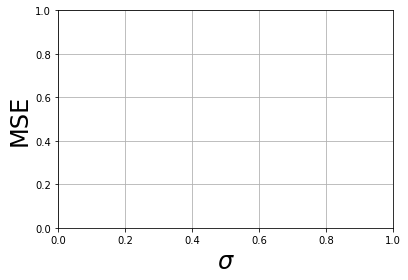

In [26]:
# troubleshoot/debug
# train models
MSE_list = []
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    print(sigmaVal)
    #noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    noise = cn.powerlaw_psd_gaussian(beta, (n_of_ic, len(tvals), feature_count)) * (sigmaVal + 0.03)
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    model.print()
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        # problem area with warnings
        print(netswitch_x0s[k])
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint", integrator_kws=integrator_keywords)
        simulations.append(netswitch_sim) 
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
    MSE_list.append(MSE)
    print(f"List for sigma={sigmaVal}: {MSE_list}")
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
#plt.yscale('log')

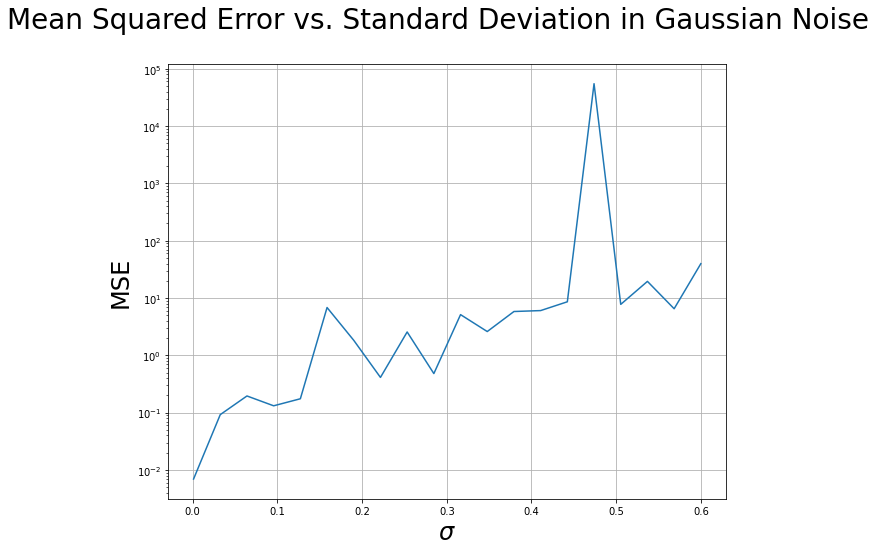

In [29]:
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
plt.yscale('log')

0.001
(u)' = -1.072 u + 7.001 1/(1 + u^1) + -3.777 1/(1 + v^1) + -8.236 1/(1 + u^2) + 13.636 1/(1 + v^2) + -17.845 1/(1 + v^3) + 2.738 1/(1 + u^4) + 7.562 1/(1 + v^4) + 0.133 1/(1 + v^5)
(v)' = -1.026 v + -7.046 1/(1 + u^1) + 41.285 1/(1 + u^2) + -8.947 1/(1 + v^2) + -88.352 1/(1 + u^3) + 37.776 1/(1 + v^3) + 85.457 1/(1 + u^4) + -49.521 1/(1 + v^4) + -30.327 1/(1 + u^5) + 20.735 1/(1 + v^5)
0.06755555555555555
(u)' = -0.813 u + 5.615 1/(1 + u^1) + -2.469 1/(1 + v^1) + -30.482 1/(1 + u^2) + 13.259 1/(1 + v^2) + 65.847 1/(1 + u^3) + -7.969 1/(1 + v^3) + -71.226 1/(1 + u^4) + -15.397 1/(1 + v^4) + 30.278 1/(1 + u^5) + 13.008 1/(1 + v^5)
(v)' = -1.081 v + 0.609 1/(1 + u^1) + 4.167 1/(1 + v^1) + 4.745 1/(1 + u^2) + -5.514 1/(1 + v^2) + -6.820 1/(1 + u^3) + -13.397 1/(1 + v^3) + -0.162 1/(1 + u^4) + 31.194 1/(1 + v^4) + 3.319 1/(1 + u^5) + -16.818 1/(1 + v^5)
0.1341111111111111
(u)' = -1.369 u + 0.894 v + 3.030 1/(1 + v^1) + -7.303 1/(1 + u^2) + 4.579 1/(1 + u^3) + -8.582 1/(1 + v^3) + 5.62

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.4003333333333333
(u)' = 0.947 v + -5.166 1/(1 + u^1) + -2.085 1/(1 + v^1) + -18.512 1/(1 + u^2) + -12.478 1/(1 + v^2) + 36.144 1/(1 + u^3) + 14.365 1/(1 + v^3) + 21.129 1/(1 + u^4) + 12.561 1/(1 + v^4) + -34.393 1/(1 + u^5) + -13.531 1/(1 + v^5)
(v)' = -0.737 u + -0.821 1/(1 + v^1) + -3.166 1/(1 + u^2) + 5.653 1/(1 + v^2) + 2.933 1/(1 + u^3) + 4.905 1/(1 + u^4) + -8.086 1/(1 + v^4) + -4.879 1/(1 + u^5) + 4.085 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = -4.770 1/(1 + u^1) + 1.236 1/(1 + v^1) + -9.648 1/(1 + u^2) + 13.013 1/(1 + v^2) + 20.814 1/(1 + u^3) + -15.740 1/(1 + v^3) + 3.921 1/(1 + u^4) + -17.809 1/(1 + v^4) + -10.840 1/(1 + u^5) + 20.053 1/(1 + v^5)
(v)' = 2.102 1/(1 + u^1) + 1.673 1/(1 + v^1) + -3.098 1/(1 + u^2) + -1.672 1/(1 + v^2) + -11.714 1/(1 + u^3) + -5.017 1/(1 + v^3) + 3.403 1/(1 + u^4) + 5.117 1/(1 + v^4) + 9.023 1/(1 + u^5)
0.5334444444444444
(u)' = -6.761 1/(1 + u^1) + 4.627 1/(1 + v^1) + -13.854 1/(1 + u^2) + 12.201 1/(1 + v^2) + 36.209 1/(1 + u^3) + -28.577 1/(1 + v^3) + 9.974 1/(1 + u^4) + -11.961 1/(1 + v^4) + -26.539 1/(1 + u^5) + 24.489 1/(1 + v^5)
(v)' = -1.171 1/(1 + u^1) + -1.300 1/(1 + v^1) + -5.902 1/(1 + u^2) + -4.424 1/(1 + v^2) + 7.837 1/(1 + v^3) + 0.658 1/(1 + u^4) + 5.306 1/(1 + v^4) + 5.851 1/(1 + u^5) + -6.561 1/(1 + v^5)
0.6
(u)' = -5.401 1/(1 + v^1) + 4.725 1/(1 + u^2) + -11.873 1/(1 + v^2) + 1.496 1/(1 + u^3) + 30.882 1/(1 + v^3) + -2.876 1/(1 + u^4) + 9.609 1/(1 +

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.0010550913954350727, 0.11063429336984976, 0.11868538277051725, 0.7816262365161329, 0.30424318340607276, 1.4730096952090788, 1.2042068082046127, 0.9676818579026083, 2.7954007861098384, 10.03425205378798]
0.001
(u)' = -1.288 u + 12.079 1/(1 + u^1) + 0.109 1/(1 + v^1) + -17.031 1/(1 + u^2) + -1.079 1/(1 + v^2) + 0.653 1/(1 + v^3) + 14.502 1/(1 + u^4) + -7.494 1/(1 + u^5)
(v)' = -1.308 v + 7.359 1/(1 + u^1) + 1.905 1/(1 + v^1) + -6.375 1/(1 + u^2) + -20.192 1/(1 + v^2) + 50.708 1/(1 + v^3) + 2.107 1/(1 + u^4) + -54.435 1/(1 + v^4) + 20.706 1/(1 + v^5)
0.06755555555555555
(u)' = -0.962 u + 4.139 1/(1 + u^1) + 5.596 1/(1 + v^1) + -53.413 1/(1 + u^2) + -1.316 1/(1 + v^2) + 160.439 1/(1 + u^3) + -196.595 1/(1 + u^4) + -9.948 1/(1 + v^4) + 84.230 1/(1 + u^5) + 7.807 1/(1 + v^5)
(v)' = -1.190 v + -1.982 1/(1 + u^1) + 1.995 1/(1 + v^1) + 29.303 1/(1 + u^2) + -2.828 1/(1 + v^2) + -89

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.4003333333333333
(u)' = -0.901 1/(1 + u^1) + 5.666 1/(1 + u^2) + -12.482 1/(1 + v^2) + 2.702 1/(1 + u^3) + 8.343 1/(1 + v^3) + -5.777 1/(1 + u^4) + 15.977 1/(1 + v^4) + -13.918 1/(1 + v^5)
(v)' = -1.971 1/(1 + u^1) + 2.716 1/(1 + v^1) + -12.033 1/(1 + u^2) + 3.149 1/(1 + v^2) + 17.073 1/(1 + u^3) + -7.013 1/(1 + v^3) + 14.083 1/(1 + u^4) + 4.166 1/(1 + v^4) + -18.599 1/(1 + u^5) + -1.863 1/(1 + v^5)
0.46688888888888885
(u)' = 3.313 1/(1 + u^1) + 17.619 1/(1 + u^2) + -8.362 1/(1 + v^2) + -18.884 1/(1 + u^3) + -1.620 1/(1 + v^3) + -14.752 1/(1 + u^4) + 5.053 1/(1 + v^4) + 14.910 1/(1 + u^5) + 2.718 1/(1 + v^5)
(v)' = -1.937 1/(1 + u^1) + 1.608 1/(1 + v^1) + 3.369 1/(1 + u^2) + 1.528 1/(1 + v^2) + 9.590 1/(1 + u^3) + -13.730 1/(1 + v^3) + -3.051 1/(1 + u^4) + -6.000 1/(1 + v^4) + -6.288 1/(1 + u^5) + 14.839 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.5334444444444444
(u)' = -2.165 1/(1 + v^1) + 4.226 1/(1 + u^2) + -7.309 1/(1 + v^2) + 3.521 1/(1 + u^3) + 11.064 1/(1 + v^3) + 3.908 1/(1 + v^4) + -5.869 1/(1 + u^5) + -7.614 1/(1 + v^5)
(v)' = -1.304 1/(1 + u^1) + -1.782 1/(1 + v^1) + -8.300 1/(1 + u^2) + 2.851 1/(1 + v^2) + 1.117 1/(1 + u^3) + 3.690 1/(1 + v^3) + 3.031 1/(1 + u^4) + -6.352 1/(1 + v^4) + 4.657 1/(1 + u^5) + 2.754 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.6
(u)' = 2.152 1/(1 + v^1) + -0.523 1/(1 + u^2) + 1.680 1/(1 + u^3) + -2.744 1/(1 + v^3) + 1.046 1/(1 + u^4) + 6.761 1/(1 + v^4) + -2.800 1/(1 + u^5) + -6.217 1/(1 + v^5)
(v)' = -2.880 1/(1 + u^1) + 1.077 1/(1 + v^1) + -2.328 1/(1 + u^2) + -9.796 1/(1 + v^2) + 15.972 1/(1 + u^3) + 3.600 1/(1 + u^4) + 12.065 1/(1 + v^4) + -12.205 1/(1 + u^5) + -5.368 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.003640583233622771, 0.14470352813811915, 0.26254522921478163, 0.4332246491067572, 7.355216054237609, 11.130413436012592, 2.355144170207471, 25.783720912167038, 15.54532273296697, 38.14941784344314]
0.001
(u)' = -1.044 u + -1.919 1/(1 + u^1) + 3.097 1/(1 + v^1) + 22.059 1/(1 + u^2) + -2.813 1/(1 + v^2) + -60.622 1/(1 + u^3) + 64.565 1/(1 + u^4) + -23.964 1/(1 + u^5) + 0.682 1/(1 + v^5)
(v)' = -1.271 v + 3.889 1/(1 + u^1) + 1.396 1/(1 + v^2) + -4.638 1/(1 + u^3) + -6.321 1/(1 + v^4) + 3.000 1/(1 + u^5) + 4.343 1/(1 + v^5)
0.06755555555555555
(u)' = -0.614 u + 2.160 1/(1 + v^1) + 0.343 1/(1 + u^2) + -31.893 1/(1 + v^2) + 23.564 1/(1 + u^3) + 69.211 1/(1 + v^3) + -56.932 1/(1 + u^4) + -55.880 1/(1 + v^4) + 34.031 1/(1 + u^5) + 15.346 1/(1 + v^5)
(v)' = -1.691 v + 0.888 1/(1 + u^1) + 8.872 1/(1 + v^1) + 10.296 1/(1 + u^2) + -16.659 1/(1 + v^2) + -24.847 1/(1 + u^3) + 37.365 1/

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.20066666666666666
(u)' = -0.689 u + -1.313 1/(1 + u^1) + 2.549 1/(1 + v^1) + -6.840 1/(1 + u^2) + 22.822 1/(1 + v^2) + 6.943 1/(1 + u^3) + -24.886 1/(1 + v^3) + 4.286 1/(1 + u^4) + -28.200 1/(1 + v^4) + -4.618 1/(1 + u^5) + 30.184 1/(1 + v^5)
(v)' = -1.555 1/(1 + u^1) + -4.920 1/(1 + v^1) + -1.837 1/(1 + u^2) + 1.009 1/(1 + v^2) + 4.527 1/(1 + u^3) + 15.274 1/(1 + v^3) + -0.638 1/(1 + u^4) + -11.626 1/(1 + v^4) + -0.609 1/(1 + u^5)
0.2672222222222222
(u)' = -1.995 1/(1 + u^1) + -12.458 1/(1 + u^2) + -6.248 1/(1 + v^2) + 15.756 1/(1 + u^3) + 7.479 1/(1 + v^3) + 13.992 1/(1 + u^4) + 10.701 1/(1 + v^4) + -16.146 1/(1 + u^5) + -11.777 1/(1 + v^5)
(v)' = -0.920 v + 2.585 1/(1 + v^1) + 5.115 1/(1 + u^2) + 17.307 1/(1 + v^2) + -20.694 1/(1 + v^3) + -4.123 1/(1 + u^4) + -20.429 1/(1 + v^4) + 21.762 1/(1 + v^5)
0.33377777777777773
(u)' = -1.500 1/(1 + u^1) + 1.735 1/(1 + v^1) + -3.132 1/(1 + u^2) + 3.438 1/(1 + v^2) + 4.937 1/(1 + u^3) + -10.470 1/(1 + v^3) + -2.940 1/(1 + v^4) + -0.739 1/(1 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.4003333333333333
(u)' = -0.899 1/(1 + u^1) + -1.245 1/(1 + v^1) + -3.765 1/(1 + u^2) + -9.378 1/(1 + v^2) + 16.633 1/(1 + u^3) + 9.002 1/(1 + v^3) + 12.312 1/(1 + u^4) + 8.914 1/(1 + v^4) + -23.172 1/(1 + u^5) + -8.783 1/(1 + v^5)
(v)' = -0.860 v + -1.164 1/(1 + u^1) + -0.978 1/(1 + v^1) + 1.110 1/(1 + u^2) + 7.475 1/(1 + v^2) + 9.582 1/(1 + u^3) + 2.472 1/(1 + u^4) + -12.293 1/(1 + v^4) + -10.115 1/(1 + u^5) + 4.892 1/(1 + v^5)
0.46688888888888885
(u)' = -0.588 u + -0.684 1/(1 + u^1) + 4.237 1/(1 + v^1) + -2.124 1/(1 + u^2) + 8.720 1/(1 + v^2) + 4.557 1/(1 + u^3) + -20.563 1/(1 + v^3) + -2.672 1/(1 + v^4) + -4.173 1/(1 + u^5) + 13.177 1/(1 + v^5)
(v)' = 2.739 1/(1 + u^1) + -5.147 1/(1 + v^1) + 3.282 1/(1 + u^2) + -14.991 1/(1 + v^2) + -12.491 1/(1 + u^3) + 33.524 1/(1 + v^3) + -0.564 1/(1 + u^4) + 16.161 1/(1 + v^4) + 7.123 1/(1 + u^5) + -30.134 1/(1 + v^5)
0.5334444444444444
(u)' = -0.501 u + 0.612 v + 0.875 1/(1 + u^1) + -4.722 1/(1 + v^1) + 2.025 1/(1 + u^2) + -12.699 1/(1 + v^2)

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.33377777777777773
(u)' = -3.554 1/(1 + u^1) + -1.404 1/(1 + v^1) + -10.388 1/(1 + u^2) + 25.937 1/(1 + u^3) + 2.068 1/(1 + v^3) + 13.654 1/(1 + u^4) + -4.696 1/(1 + v^4) + -25.462 1/(1 + u^5) + 3.543 1/(1 + v^5)
(v)' = -3.494 1/(1 + u^1) + -3.105 1/(1 + v^1) + -10.606 1/(1 + u^2) + 19.986 1/(1 + u^3) + 17.283 1/(1 + v^3) + 8.798 1/(1 + u^4) + -15.830 1/(1 + u^5) + -13.243 1/(1 + v^5)
0.4003333333333333
(u)' = -2.822 1/(1 + u^1) + -3.485 1/(1 + v^1) + 2.082 1/(1 + u^2) + 2.403 1/(1 + v^2) + 10.757 1/(1 + u^3) + 10.436 1/(1 + v^3) + -6.169 1/(1 + u^4) + -9.099 1/(1 + v^4) + -3.823 1/(1 + u^5)
(v)' = -0.577 u + 1.846 1/(1 + u^1) + -2.863 1/(1 + v^1) + 4.364 1/(1 + u^2) + -6.715 1/(1 + v^2) + -6.844 1/(1 + u^3) + 21.272 1/(1 + v^3) + -1.889 1/(1 + u^4) + 10.236 1/(1 + v^4) + 2.177 1/(1 + u^5) + -21.154 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = 2.114 1/(1 + u^1) + -4.340 1/(1 + v^1) + 5.137 1/(1 + u^2) + -8.926 1/(1 + v^2) + -11.239 1/(1 + u^3) + 15.210 1/(1 + v^3) + -2.377 1/(1 + u^4) + 8.167 1/(1 + u^5) + -3.690 1/(1 + v^5)
(v)' = -5.037 1/(1 + u^1) + -1.115 1/(1 + v^1) + -11.384 1/(1 + u^2) + 6.306 1/(1 + v^2) + 29.391 1/(1 + u^3) + 1.040 1/(1 + v^3) + 9.712 1/(1 + u^4) + -8.897 1/(1 + v^4) + -23.799 1/(1 + u^5) + 3.820 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.5334444444444444
(u)' = -1.191 1/(1 + u^1) + -3.302 1/(1 + u^2) + 2.241 1/(1 + v^2) + 1.737 1/(1 + v^3) + -2.596 1/(1 + u^4) + 5.925 1/(1 + u^5) + -2.901 1/(1 + v^5)
(v)' = 2.628 1/(1 + u^1) + -3.540 1/(1 + v^1) + 3.081 1/(1 + u^2) + -19.442 1/(1 + u^3) + 20.977 1/(1 + v^3) + -6.568 1/(1 + u^4) + 0.994 1/(1 + v^4) + 19.235 1/(1 + u^5) + -17.252 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.6
(u)' = -1.741 1/(1 + u^1) + 2.912 1/(1 + v^1) + -11.253 1/(1 + u^2) + 0.887 1/(1 + v^2) + 6.935 1/(1 + u^3) + -8.262 1/(1 + v^3) + 8.036 1/(1 + u^4) + 6.003 1/(1 + v^4) + -2.900 1/(1 + u^5) + -0.850 1/(1 + v^5)
(v)' = -6.802 1/(1 + u^1) + -0.648 1/(1 + v^1) + -24.243 1/(1 + u^2) + 3.649 1/(1 + v^2) + 43.879 1/(1 + u^3) + 4.865 1/(1 + v^3) + 24.718 1/(1 + u^4) + -1.350 1/(1 + v^4) + -39.133 1/(1 + u^5) + -4.953 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.004516584375875717, 0.8356066591029938, 1.3638486776150098, 0.14315202933283505, 0.3991734980664596, 1.1188346459286096, 1.6141244708975901, 1.1110267890349768, 2.2724606860836505, 84.87471051692015]
0.001
(u)' = -1.096 u + 2.611 1/(1 + u^1) + 0.361 1/(1 + v^1) + 5.383 1/(1 + v^2) + -3.774 1/(1 + u^3) + -8.140 1/(1 + v^3) + -2.314 1/(1 + u^4) + 4.098 1/(1 + u^5) + 3.004 1/(1 + v^5)
(v)' = -1.165 v + 2.342 1/(1 + u^1) + -0.704 1/(1 + v^1) + -4.401 1/(1 + u^3) + 11.505 1/(1 + v^3) + 3.682 1/(1 + u^4) + -20.101 1/(1 + v^4) + 9.113 1/(1 + v^5)
0.06755555555555555
(u)' = -0.850 u + -10.196 1/(1 + u^2) + 10.752 1/(1 + v^2) + 27.891 1/(1 + u^3) + -16.608 1/(1 + v^3) + -33.607 1/(1 + u^4) + 7.267 1/(1 + v^4) + 15.177 1/(1 + u^5)
(v)' = -1.389 v + 5.986 1/(1 + u^1) + 6.818 1/(1 + v^1) + -18.209 1/(1 + u^2) + 16.737 1/(1 + u^3) + -26.076 1/(1 + v^3) + -2.525 1/(1 + u^4) + 38.458 1/

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.33377777777777773
(u)' = -0.585 u + -2.426 1/(1 + u^1) + 5.562 1/(1 + v^1) + -0.551 1/(1 + u^2) + 6.225 1/(1 + v^2) + 9.230 1/(1 + u^3) + -22.362 1/(1 + v^3) + -3.510 1/(1 + u^4) + 2.267 1/(1 + v^4) + -3.245 1/(1 + u^5) + 9.412 1/(1 + v^5)
(v)' = -0.911 1/(1 + u^1) + -1.116 1/(1 + v^1) + -2.430 1/(1 + u^2) + -10.544 1/(1 + v^2) + 2.003 1/(1 + u^3) + 16.271 1/(1 + v^3) + 16.588 1/(1 + v^4) + 1.230 1/(1 + u^5) + -21.500 1/(1 + v^5)
0.4003333333333333
(u)' = 1.300 1/(1 + u^1) + 2.869 1/(1 + v^1) + 8.592 1/(1 + v^2) + -7.011 1/(1 + u^3) + -18.014 1/(1 + v^3) + -8.608 1/(1 + v^4) + 5.200 1/(1 + u^5) + 15.679 1/(1 + v^5)
(v)' = 0.500 1/(1 + u^1) + -3.690 1/(1 + u^2) + 1.312 1/(1 + v^2) + 1.552 1/(1 + u^3) + 6.395 1/(1 + u^4) + -1.133 1/(1 + v^4) + -5.099 1/(1 + u^5)
0.46688888888888885
(u)' = 1.309 1/(1 + u^1) + 0.833 1/(1 + v^1) + -5.223 1/(1 + u^2) + -3.610 1/(1 + v^2) + -3.928 1/(1 + u^3) + 1.627 1/(1 + v^3) + 7.225 1/(1 + u^4) + 8.159 1/(1 + v^4) + -6.873 1/(1 + v^5)
(v)' = 1.508 1/(1 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.6
(u)' = 3.676 1/(1 + u^1) + -1.258 1/(1 + v^1) + 17.065 1/(1 + u^2) + -12.286 1/(1 + v^2) + -29.958 1/(1 + u^3) + 13.076 1/(1 + v^3) + -20.105 1/(1 + u^4) + 13.488 1/(1 + v^4) + 31.498 1/(1 + u^5) + -15.499 1/(1 + v^5)
(v)' = 3.172 1/(1 + u^1) + 1.329 1/(1 + v^1) + 6.986 1/(1 + u^2) + -5.961 1/(1 + v^2) + -17.202 1/(1 + u^3) + -3.983 1/(1 + v^3) + -5.138 1/(1 + u^4) + 7.850 1/(1 + v^4) + 12.845 1/(1 + u^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.0013584104045502377, 0.13101146053508372, 0.21868047533786067, 4.72503799057672, 2.314772515167494, 0.8386984035437266, 60.797558731037014, 26.26339633365611, 50.65058748619957, 26.721182114969427]
0.001
(u)' = -1.041 u + -11.917 1/(1 + u^1) + 29.505 1/(1 + v^1) + 46.025 1/(1 + u^2) + -105.000 1/(1 + v^2) + -95.694 1/(1 + u^3) + 174.426 1/(1 + v^3) + 93.518 1/(1 + u^4) + -137.566 1/(1 + v^4) + -33.865 1/(1 + u^5) + 41.679 1/(1 + v^5)
(v)' = -1.399 v + 2.251 1/(1 + u^

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.20066666666666666
(u)' = -0.644 u + 0.537 v + -3.681 1/(1 + u^1) + 1.824 1/(1 + v^1) + -1.512 1/(1 + u^2) + -3.542 1/(1 + v^2) + 11.393 1/(1 + u^3) + -3.404 1/(1 + v^3) + -6.373 1/(1 + u^4) + 8.658 1/(1 + v^4) + -0.599 1/(1 + u^5) + -3.178 1/(1 + v^5)
(v)' = -0.697 u + -0.849 1/(1 + u^1) + 3.282 1/(1 + u^2) + 10.392 1/(1 + v^2) + -5.999 1/(1 + v^3) + -7.135 1/(1 + u^4) + -12.193 1/(1 + v^4) + 4.045 1/(1 + u^5) + 9.515 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.2672222222222222
(u)' = -1.035 u + 1.534 v + -2.402 1/(1 + u^1) + 0.713 1/(1 + v^1) + -7.508 1/(1 + u^2) + -11.646 1/(1 + v^2) + 11.020 1/(1 + u^3) + 7.714 1/(1 + v^3) + 2.089 1/(1 + u^4) + 21.525 1/(1 + v^4) + -6.340 1/(1 + u^5) + -16.408 1/(1 + v^5)
(v)' = -0.895 v + 1.684 1/(1 + u^1) + 3.017 1/(1 + v^1) + 8.978 1/(1 + u^2) + 13.556 1/(1 + v^2) + -13.535 1/(1 + u^3) + -22.051 1/(1 + v^3) + -9.535 1/(1 + u^4) + -16.505 1/(1 + v^4) + 14.122 1/(1 + u^5) + 21.678 1/(1 + v^5)
0.33377777777777773
(u)' = -2.608 1/(1 + u^1) + -0.716 1/(1 + v^1) + -6.493 1/(1 + u^2) + -4.262 1/(1 + v^2) + 16.610 1/(1 + u^3) + 4.589 1/(1 + v^3) + 7.458 1/(1 + u^4) + 3.696 1/(1 + v^4) + -14.633 1/(1 + u^5) + -4.054 1/(1 + v^5)
(v)' = 4.309 1/(1 + u^2) + -8.536 1/(1 + v^2) + 1.969 1/(1 + u^3) + 4.210 1/(1 + v^3) + -1.623 1/(1 + u^4) + 9.793 1/(1 + v^4) + -3.325 1/(1 + u^5) + -7.064 1/(1 + v^5)
0.4003333333333333
(u)' = 1.110 1/(1 + v^1) + 12.868 1/(1 + u^2) + -17.074 1/(1 + v^2) + -9.168 1/(1 + u^3) + 6.173 1/

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.5334444444444444
(u)' = -2.823 1/(1 + u^1) + -0.577 1/(1 + v^1) + 3.743 1/(1 + u^2) + -7.582 1/(1 + v^2) + 15.054 1/(1 + u^3) + 5.575 1/(1 + v^3) + -3.076 1/(1 + u^4) + 6.755 1/(1 + v^4) + -10.957 1/(1 + u^5) + -6.403 1/(1 + v^5)
(v)' = -3.909 1/(1 + u^1) + 3.217 1/(1 + v^1) + -11.422 1/(1 + u^2) + 8.454 1/(1 + v^2) + 21.730 1/(1 + u^3) + -23.749 1/(1 + v^3) + 9.117 1/(1 + u^4) + -9.980 1/(1 + v^4) + -16.665 1/(1 + u^5) + 23.495 1/(1 + v^5)
0.6
(u)' = 0.673 v + -4.299 1/(1 + u^1) + -5.655 1/(1 + v^1) + -16.112 1/(1 + u^2) + -6.448 1/(1 + v^2) + 22.189 1/(1 + u^3) + 23.522 1/(1 + v^3) + 11.214 1/(1 + u^4) + 1.163 1/(1 + v^4) + -15.493 1/(1 + u^5) + -10.932 1/(1 + v^5)
(v)' = -5.796 1/(1 + u^1) + -2.599 1/(1 + v^1) + -11.309 1/(1 + u^2) + -7.055 1/(1 + v^2) + 35.126 1/(1 + u^3) + 17.848 1/(1 + v^3) + 10.945 1/(1 + u^4) + 9.244 1/(1 + v^4) + -29.567 1/(1 + u^5) + -16.773 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.001539739144589016, 0.051744241486479374, 0.1890469943371075, 0.517840593825108, 0.4838401769657421, 3.236832711122071, 29.011122364512673, 105.36825331572754, 2.0898629993524267, 112.30581536067099]
0.001
(u)' = -1.278 u + 14.142 1/(1 + u^1) + 4.602 1/(1 + v^1) + -34.157 1/(1 + u^2) + -12.205 1/(1 + v^2) + 28.220 1/(1 + u^3) + 15.155 1/(1 + v^3) + -2.203 1/(1 + u^4) + -8.957 1/(1 + v^4) + -4.837 1/(1 + u^5) + 1.923 1/(1 + v^5)
(v)' = -1.002 v + -1.502 1/(1 + u^1) + -3.943 1/(1 + v^1) + 16.613 1/(1 + u^2) + 8.837 1/(1 + v^2) + -35.317 1/(1 + u^3) + 30.889 1/(1 + u^4) + -13.730 1/(1 + v^4) + -9.206 1/(1 + u^5) + 8.377 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.06755555555555555
(u)' = -1.160 u + 0.636 v + -1.755 1/(1 + u^1) + 4.530 1/(1 + v^1) + -18.065 1/(1 + u^2) + -4.744 1/(1 + v^2) + 61.807 1/(1 + u^3) + -81.368 1/(1 + u^4) + 8.726 1/(1 + v^4) + 37.263 1/(1 + u^5) + -6.250 1/(1 + v^5)
(v)' = -1.215 v + -3.583 1/(1 + u^1) + 2.309 1/(1 + v^1) + 22.029 1/(1 + u^2) + 17.806 1/(1 + v^2) + -46.338 1/(1 + u^3) + -54.389 1/(1 + v^3) + 44.318 1/(1 + u^4) + 51.505 1/(1 + v^4) + -15.389 1/(1 + u^5) + -16.657 1/(1 + v^5)
0.1341111111111111
(u)' = -0.860 u + 0.861 v + -4.988 1/(1 + v^1) + 3.540 1/(1 + u^2) + -9.065 1/(1 + v^2) + -5.132 1/(1 + u^3) + 24.993 1/(1 + v^3) + -7.679 1/(1 + u^4) + -9.173 1/(1 + v^4) + 8.623 1/(1 + u^5) + -2.078 1/(1 + v^5)
(v)' = 0.501 u + -1.286 v + -1.422 1/(1 + u^1) + 1.526 1/(1 + v^1) + 3.129 1/(1 + u^2) + 5.577 1/(1 + v^2) + 3.011 1/(1 + u^3) + -15.014 1/(1 + v^3) + -8.802 1/(1 + u^4) + 12.823 1/(1 + v^4) + 5.416 1/(1 + u^5) + -5.209 1/(1 + v^5)
0.20066666666666666
(u)' = -0.894 u + 1.089 v + -1.342 1/(1 + u^1) + 1.1

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = -2.845 1/(1 + u^1) + -0.908 1/(1 + v^1) + -4.896 1/(1 + u^2) + -8.258 1/(1 + v^2) + 19.203 1/(1 + u^3) + 7.200 1/(1 + v^3) + 7.726 1/(1 + u^4) + 7.648 1/(1 + v^4) + -17.777 1/(1 + u^5) + -7.460 1/(1 + v^5)
(v)' = 5.145 1/(1 + u^1) + -1.894 1/(1 + v^1) + 11.034 1/(1 + u^2) + -31.113 1/(1 + u^3) + 6.635 1/(1 + v^3) + -11.604 1/(1 + u^4) + -2.714 1/(1 + v^4) + 26.130 1/(1 + u^5) + -1.567 1/(1 + v^5)
0.5334444444444444
(u)' = -0.591 u + 1.453 1/(1 + u^1) + -2.051 1/(1 + v^1) + 7.054 1/(1 + u^2) + 9.294 1/(1 + v^2) + -9.654 1/(1 + u^3) + 8.744 1/(1 + v^3) + -9.687 1/(1 + u^4) + -9.225 1/(1 + v^4) + 8.827 1/(1 + u^5) + -4.323 1/(1 + v^5)
(v)' = -2.526 1/(1 + v^1) + -0.589 1/(1 + u^2) + -0.700 1/(1 + v^2) + 1.540 1/(1 + u^3) + 9.974 1/(1 + v^3) + 1.104 1/(1 + u^4) + -2.167 1/(1 + v^4) + -2.571 1/(1 + u^5) + -3.990 1/(1 + v^5)
0.6
(u)' = -3.692 1/(1 + u^1) + -3.451 1/(1 + v^1) + -15.780 1/(1 + u^2) + 3.649 1/(1 + v^2) + 29.833 1/(1 + u^3) + 20.881 1/(1 + v^3) + 18.62

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.33377777777777773
(u)' = -1.947 1/(1 + u^1) + 3.164 1/(1 + v^1) + -10.059 1/(1 + u^2) + 3.278 1/(1 + v^2) + 15.752 1/(1 + u^3) + -16.116 1/(1 + v^3) + 12.150 1/(1 + u^4) + -0.993 1/(1 + v^4) + -16.515 1/(1 + u^5) + 10.994 1/(1 + v^5)
(v)' = -2.517 1/(1 + u^1) + 10.735 1/(1 + u^3) + -2.825 1/(1 + u^4) + -5.309 1/(1 + u^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.4003333333333333
(u)' = -2.740 1/(1 + u^2) + -2.580 1/(1 + v^2) + 7.557 1/(1 + u^3) + -2.544 1/(1 + v^3) + 8.427 1/(1 + u^4) + -12.595 1/(1 + u^5) + 4.179 1/(1 + v^5)
(v)' = -0.860 1/(1 + u^1) + 2.725 1/(1 + v^1) + -5.635 1/(1 + u^2) + 1.416 1/(1 + v^2) + 9.634 1/(1 + u^3) + -13.941 1/(1 + v^3) + 8.516 1/(1 + u^4) + -11.758 1/(1 + u^5) + 9.575 1/(1 + v^5)
0.46688888888888885
(u)' = 5.146 1/(1 + v^1) + 8.198 1/(1 + u^2) + 4.688 1/(1 + v^2) + -3.843 1/(1 + u^3) + -23.784 1/(1 + v^3) + -9.969 1/(1 + u^4) + -0.867 1/(1 + v^4) + 6.378 1/(1 + u^5) + 13.939 1/(1 + v^5)
(v)' = -0.668 v + 5.544 1/(1 + v^2) + -1.341 1/(1 + u^3) + 6.367 1/(1 + v^3) + -1.468 1/(1 + v^4) + 2.216 1/(1 + u^5) + -10.624 1/(1 + v^5)
0.5334444444444444
(u)' = -0.888 1/(1 + u^1) + -2.435 1/(1 + v^1) + 9.588 1/(1 + u^2) + -10.542 1/(1 + v^2) + 16.536 1/(1 + v^3) + -10.913 1/(1 + u^4) + 9.436 1/(1 + v^4) + 4.444 1/(1 + u^5) + -15.361 1/(1 + v^5)
(v)' = -2.406 1/(1 + u^1) + -4.898 1/(1 + v^1) + -5.224 1/(1 + u^2) + -4.000

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.6
(u)' = 0.520 v + -6.015 1/(1 + u^1) + -1.044 1/(1 + v^1) + -15.532 1/(1 + u^2) + 9.538 1/(1 + v^2) + 30.290 1/(1 + u^3) + 7.779 1/(1 + u^4) + -10.300 1/(1 + v^4) + -20.420 1/(1 + u^5) + 5.236 1/(1 + v^5)
(v)' = -2.013 1/(1 + u^1) + 2.449 1/(1 + v^1) + -10.630 1/(1 + u^2) + 13.293 1/(1 + v^2) + 13.601 1/(1 + u^3) + -16.868 1/(1 + v^3) + 9.676 1/(1 + u^4) + -13.009 1/(1 + v^4) + -12.601 1/(1 + u^5) + 15.870 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.003172038874047902, 0.05399418780034494, 0.11202280979680043, 0.3263098472781715, 7.277433387658719, 3.7452658290990857, 6.094850785579832, 39.62366194613697, 3.1007263076870926, 369.54887468004637]
0.001
(u)' = -1.210 u + 12.919 1/(1 + u^1) + -6.431 1/(1 + v^1) + -27.282 1/(1 + u^2) + 27.103 1/(1 + v^2) + 24.776 1/(1 + u^3) + -44.473 1/(1 + v^3) + -10.442 1/(1 + u^4) + 30.672 1/(1 + v^4) + 1.757 1/(1 + u^5) + -7.131 1/(1 + v^5)
(v)' = -1.163 v + -3.955 1

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.2672222222222222
(u)' = -4.664 1/(1 + u^2) + -1.180 1/(1 + v^2) + 6.174 1/(1 + u^3) + -0.732 1/(1 + v^3) + 9.036 1/(1 + u^4) + -10.253 1/(1 + u^5) + 1.239 1/(1 + v^5)
(v)' = -0.639 1/(1 + v^1) + 1.604 1/(1 + u^2) + -8.393 1/(1 + v^2) + -2.523 1/(1 + u^3) + 11.152 1/(1 + v^3) + -2.888 1/(1 + u^4) + 12.650 1/(1 + v^4) + 4.189 1/(1 + u^5) + -15.403 1/(1 + v^5)
0.33377777777777773
(u)' = -2.800 1/(1 + u^1) + 1.646 1/(1 + v^1) + -12.848 1/(1 + u^2) + 21.073 1/(1 + u^3) + -3.737 1/(1 + v^3) + 14.840 1/(1 + u^4) + 4.486 1/(1 + v^4) + -21.126 1/(1 + u^5) + -1.991 1/(1 + v^5)
(v)' = -1.454 1/(1 + u^1) + -0.797 1/(1 + v^1) + -13.478 1/(1 + u^2) + 7.294 1/(1 + v^2) + 15.380 1/(1 + u^3) + 16.372 1/(1 + u^4) + -9.139 1/(1 + v^4) + -18.358 1/(1 + u^5) + 4.005 1/(1 + v^5)
0.4003333333333333
(u)' = -2.524 1/(1 + u^1) + 2.957 1/(1 + v^1) + -6.102 1/(1 + u^2) + 5.949 1/(1 + v^2) + 16.446 1/(1 + u^3) + -19.469 1/(1 + v^3) + 6.977 1/(1 + u^4) + -7.366 1/(1 + v^4) + -14.795 1/(1 + u^5) + 17.666 1/(1 + v^

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = 1.791 1/(1 + v^1) + -10.165 1/(1 + u^2) + 11.724 1/(1 + v^2) + 2.755 1/(1 + u^3) + -11.294 1/(1 + v^3) + 10.039 1/(1 + u^4) + -10.170 1/(1 + v^4) + -4.629 1/(1 + u^5) + 9.845 1/(1 + v^5)
(v)' = 1.328 1/(1 + u^2) + 0.914 1/(1 + v^2) + -8.836 1/(1 + u^3) + 4.880 1/(1 + v^3) + -7.637 1/(1 + u^4) + 2.820 1/(1 + v^4) + 14.728 1/(1 + u^5) + -8.091 1/(1 + v^5)
0.5334444444444444
(u)' = 0.718 v + -1.588 1/(1 + u^1) + 0.903 1/(1 + v^1) + -14.000 1/(1 + u^2) + -13.317 1/(1 + v^2) + 26.363 1/(1 + u^3) + -2.674 1/(1 + v^3) + 25.706 1/(1 + u^4) + 13.242 1/(1 + v^4) + -36.033 1/(1 + u^5)
(v)' = -0.537 u + 1.424 1/(1 + v^1) + -8.732 1/(1 + u^2) + 7.021 1/(1 + v^2) + 2.332 1/(1 + u^3) + -10.389 1/(1 + v^3) + 9.238 1/(1 + u^4) + -6.741 1/(1 + v^4) + -3.889 1/(1 + u^5) + 10.204 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitat

0.6
(u)' = 5.971 1/(1 + u^1) + -2.281 1/(1 + v^1) + 21.904 1/(1 + u^2) + -17.579 1/(1 + v^2) + -36.764 1/(1 + u^3) + 21.596 1/(1 + v^3) + -19.566 1/(1 + u^4) + 19.742 1/(1 + v^4) + 31.415 1/(1 + u^5) + -24.576 1/(1 + v^5)
(v)' = -3.074 1/(1 + u^1) + 4.036 1/(1 + v^1) + 4.490 1/(1 + v^2) + 14.319 1/(1 + u^3) + -21.570 1/(1 + v^3) + -2.128 1/(1 + u^4) + -3.216 1/(1 + v^4) + -8.471 1/(1 + u^5) + 15.783 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.022192020296902353, 0.08639278588561046, 0.39958237579073574, 0.5309177129051067, 1.368246639946456, 1.2703652077773853, 1.1836371270395463, 37.71811450227719, 9143603.01042339, 27.212754824562893]
0.001
(u)' = -1.219 u + 9.496 1/(1 + u^1) + 2.183 1/(1 + v^1) + -19.008 1/(1 + u^2) + 5.579 1/(1 + v^2) + 5.124 1/(1 + u^3) + -25.169 1/(1 + v^3) + 14.648 1/(1 + u^4) + 29.425 1/(1 + v^4) + -9.510 1/(1 + u^5) + -11.241 1/(1 + v^5)
(v)' = -1.203 v + 0.770 1/(1 + u^1) + 5.

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.20066666666666666
(u)' = -0.957 u + 0.581 v + -4.639 1/(1 + u^1) + 6.088 1/(1 + v^1) + -5.861 1/(1 + u^2) + 1.069 1/(1 + v^2) + 20.355 1/(1 + u^3) + -18.710 1/(1 + v^3) + -0.952 1/(1 + u^4) + 13.909 1/(1 + v^4) + -10.898 1/(1 + u^5)
(v)' = -0.528 v + -3.941 1/(1 + v^1) + 2.639 1/(1 + u^2) + -2.555 1/(1 + u^3) + 13.336 1/(1 + v^3) + -3.523 1/(1 + u^4) + -5.426 1/(1 + v^4) + 4.195 1/(1 + u^5) + -4.359 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.2672222222222222
(u)' = -1.177 u + 1.284 v + -1.727 1/(1 + u^1) + 0.780 1/(1 + v^1) + -1.255 1/(1 + u^2) + -3.809 1/(1 + v^2) + 3.916 1/(1 + u^3) + 1.660 1/(1 + v^3) + -5.768 1/(1 + u^4) + 10.345 1/(1 + v^4) + 2.106 1/(1 + u^5) + -6.704 1/(1 + v^5)
(v)' = -1.931 1/(1 + u^1) + -1.252 1/(1 + v^1) + -0.830 1/(1 + v^2) + 5.792 1/(1 + u^3) + 3.764 1/(1 + v^3) + -3.664 1/(1 + u^4) + -2.019 1/(1 + v^4)
0.33377777777777773
(u)' = -3.432 1/(1 + u^1) + 1.057 1/(1 + v^1) + -2.927 1/(1 + u^2) + -3.183 1/(1 + v^2) + 15.410 1/(1 + u^3) + -3.167 1/(1 + v^3) + 4.523 1/(1 + v^4) + -8.513 1/(1 + u^5)
(v)' = 2.846 1/(1 + u^1) + -3.084 1/(1 + v^1) + 1.396 1/(1 + u^2) + 2.207 1/(1 + v^2) + -19.058 1/(1 + u^3) + 9.289 1/(1 + v^3) + -3.272 1/(1 + u^4) + -7.918 1/(1 + v^4) + 17.524 1/(1 + u^5)
0.4003333333333333
(u)' = -0.530 u + 0.836 v + -1.637 1/(1 + u^1) + -1.897 1/(1 + v^1) + -13.486 1/(1 + u^2) + 2.830 1/(1 + v^2) + 11.490 1/(1 + u^3) + 9.528 1/(1 + v^3) + 10.847 1/(1 + u^4) + -1.003 1/(1 + v^4) + -10

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.5334444444444444
(u)' = 1.011 1/(1 + u^1) + 3.225 1/(1 + u^2) + 3.611 1/(1 + v^2) + -6.497 1/(1 + u^3) + -8.495 1/(1 + v^3) + -3.508 1/(1 + u^4) + -9.086 1/(1 + v^4) + 5.780 1/(1 + u^5) + 14.138 1/(1 + v^5)
(v)' = -0.558 1/(1 + u^1) + 4.889 1/(1 + v^1) + -7.048 1/(1 + u^2) + 4.661 1/(1 + v^2) + 6.344 1/(1 + u^3) + -23.745 1/(1 + v^3) + 8.554 1/(1 + u^4) + -0.740 1/(1 + v^4) + -7.771 1/(1 + u^5) + 15.146 1/(1 + v^5)
0.6
(u)' = -4.241 1/(1 + u^1) + 2.780 1/(1 + v^1) + -4.494 1/(1 + u^2) + 12.010 1/(1 + v^2) + 24.012 1/(1 + u^3) + -17.311 1/(1 + v^3) + 2.276 1/(1 + u^4) + -11.419 1/(1 + v^4) + -18.815 1/(1 + u^5) + 14.949 1/(1 + v^5)
(v)' = 0.586 1/(1 + v^1) + -15.424 1/(1 + u^2) + 5.213 1/(1 + v^2) + 8.053 1/(1 + u^3) + 2.779 1/(1 + v^3) + 19.416 1/(1 + u^4) + -13.432 1/(1 + u^5) + -7.543 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.013699330778796228, 0.10402941676872351, 0.06005624116409813, 0.12565347

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = 3.840 1/(1 + u^1) + -5.147 1/(1 + v^1) + 11.515 1/(1 + u^2) + -20.663 1/(1 + v^2) + -19.519 1/(1 + u^3) + 35.061 1/(1 + v^3) + -8.085 1/(1 + u^4) + 22.119 1/(1 + v^4) + 13.339 1/(1 + u^5) + -32.706 1/(1 + v^5)
(v)' = 2.917 1/(1 + v^1) + -1.424 1/(1 + u^2) + -5.278 1/(1 + v^2) + -5.600 1/(1 + u^3) + -0.568 1/(1 + v^3) + -3.086 1/(1 + u^4) + 16.870 1/(1 + v^4) + 9.335 1/(1 + u^5) + -13.636 1/(1 + v^5)
0.5334444444444444
(u)' = -3.501 1/(1 + u^1) + -3.679 1/(1 + v^1) + 0.664 1/(1 + u^2) + -12.226 1/(1 + v^2) + 19.371 1/(1 + u^3) + 21.464 1/(1 + v^3) + 9.892 1/(1 + v^4) + -14.800 1/(1 + u^5) + -17.366 1/(1 + v^5)
(v)' = -2.707 1/(1 + u^1) + -6.570 1/(1 + u^2) + 15.365 1/(1 + v^2) + 8.095 1/(1 + u^3) + -7.075 1/(1 + v^3) + -18.453 1/(1 + v^4) + 11.790 1/(1 + v^5)
0.6
(u)' = 2.140 1/(1 + u^1) + -2.990 1/(1 + v^1) + -5.515 1/(1 + u^2) + -5.582 1/(1 + u^3) + 15.271 1/(1 + v^3) + 8.630 1/(1 + u^4) + -1.400 1/(1 + u^5) + -10.522 1/(1 + v^5)
(v)' = -6.721 1/(1 + u^2) + 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.005968569392431759, 0.07242376337359283, 0.3193596267816768, 0.30041473841771354, 0.7500425813997519, 513719109.7328191, 376635986.3734989, 8.573399686279163, 7.095172200541393, 26.683084571156403]
0.001
(u)' = -1.195 u + 12.051 1/(1 + u^1) + -5.225 1/(1 + v^1) + -17.087 1/(1 + u^2) + 13.090 1/(1 + v^2) + 7.116 1/(1 + u^3) + -13.527 1/(1 + v^3) + 0.359 1/(1 + u^4) + 3.317 1/(1 + v^4) + 1.439 1/(1 + v^5)
(v)' = -1.460 v + 7.333 1/(1 + u^1) + -11.368 1/(1 + v^2) + -7.428 1/(1 + u^3) + 31.716 1/(1 + v^3) + -36.860 1/(1 + v^4) + 4.015 1/(1 + u^5) + 14.720 1/(1 + v^5)
0.06755555555555555
(u)' = -1.337 u + 5.009 1/(1 + u^1) + -10.456 1/(1 + u^2) + 12.073 1/(1 + v^2) + -3.598 1/(1 + v^3) + 4.765 1/(1 + u^4) + -20.069 1/(1 + v^4) + 14.014 1/(1 + v^5)
(v)' = -0.945 v + 3.397 1/(1 + v^1) + 13.603 1/(1 + u^2) + 1.851 1/(1 + v^2) + -43.470 1/(1 + u^3) + -27.567 1/(1 + v^3) + 48.599 1

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.33377777777777773
(u)' = -1.218 1/(1 + u^1) + -1.355 1/(1 + v^1) + 4.909 1/(1 + u^2) + -1.163 1/(1 + u^3) + -9.823 1/(1 + u^4) + -6.026 1/(1 + v^4) + 8.031 1/(1 + u^5) + 6.699 1/(1 + v^5)
(v)' = 2.509 1/(1 + u^1) + -5.090 1/(1 + v^1) + 10.039 1/(1 + u^2) + -11.262 1/(1 + v^2) + -18.701 1/(1 + u^3) + 26.515 1/(1 + v^3) + -11.642 1/(1 + u^4) + 7.605 1/(1 + v^4) + 18.621 1/(1 + u^5) + -18.664 1/(1 + v^5)
0.4003333333333333
(u)' = -2.811 1/(1 + u^1) + 1.663 1/(1 + v^1) + -5.567 1/(1 + u^2) + 10.174 1/(1 + v^2) + 17.349 1/(1 + u^3) + -18.597 1/(1 + v^3) + 6.018 1/(1 + u^4) + -16.187 1/(1 + v^4) + -14.862 1/(1 + u^5) + 22.731 1/(1 + v^5)
(v)' = -3.339 1/(1 + u^1) + -4.886 1/(1 + v^1) + -3.359 1/(1 + u^2) + -12.511 1/(1 + v^2) + 20.558 1/(1 + u^3) + 27.536 1/(1 + v^3) + 5.059 1/(1 + u^4) + 9.691 1/(1 + v^4) + -17.571 1/(1 + u^5) + -21.444 1/(1 + v^5)
0.46688888888888885
(u)' = 2.277 1/(1 + u^1) + -1.251 1/(1 + v^1) + 3.647 1/(1 + u^2) + 6.467 1/(1 + v^2) + -12.529 1/(1 + u^3) + -3.068 1/(1 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.5334444444444444
(u)' = -2.680 1/(1 + u^1) + -4.099 1/(1 + v^1) + -12.080 1/(1 + u^2) + -0.694 1/(1 + v^2) + 23.574 1/(1 + u^3) + 12.329 1/(1 + v^3) + 15.672 1/(1 + u^4) + -5.947 1/(1 + v^4) + -25.896 1/(1 + u^5)
(v)' = 3.842 1/(1 + u^1) + -1.113 1/(1 + v^1) + 18.624 1/(1 + u^2) + -12.233 1/(1 + v^2) + -23.737 1/(1 + u^3) + 6.435 1/(1 + v^3) + -17.326 1/(1 + u^4) + 10.245 1/(1 + v^4) + 20.356 1/(1 + u^5) + -5.136 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.6
(u)' = -6.042 1/(1 + u^1) + -0.893 1/(1 + v^1) + -14.660 1/(1 + u^2) + -6.617 1/(1 + v^2) + 39.336 1/(1 + u^3) + 10.021 1/(1 + v^3) + 16.456 1/(1 + u^4) + 9.557 1/(1 + v^4) + -35.352 1/(1 + u^5) + -12.222 1/(1 + v^5)
(v)' = -1.289 1/(1 + v^1) + -2.836 1/(1 + u^2) + -4.184 1/(1 + v^2) + -0.758 1/(1 + u^3) + 12.346 1/(1 + v^3) + 2.197 1/(1 + u^4) + 7.041 1/(1 + v^4) + 1.265 1/(1 + u^5) + -14.126 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.0040401895735318865, 0.1968654341170381, 0.28648969496319904, 9.509233810586235, 3.5416195433482454, 1.3097641229621568, 50.60892059784235, 33543.88353257513, 13.198796617534303, 1.6332905708407375]
0.001
(u)' = -1.200 u + 5.845 1/(1 + u^1) + 10.846 1/(1 + v^1) + -13.749 1/(1 + u^2) + -26.291 1/(1 + v^2) + 0.673 1/(1 + u^3) + 28.356 1/(1 + v^3) + 17.983 1/(1 + u^4) + -12.418 1/(1 + v^4) + -10.968 1/(1 + u^5) + 1.180 1/(1 + v^5)
(v)' = -0.997 v + 3.329 1/(1 + u^1) + -

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.20066666666666666
(u)' = -1.488 u + 1.179 v + -2.482 1/(1 + u^1) + 1.086 1/(1 + v^1) + -5.092 1/(1 + u^2) + 1.552 1/(1 + v^2) + 10.395 1/(1 + u^3) + -1.537 1/(1 + v^3) + -1.319 1/(1 + u^4) + 5.103 1/(1 + v^4) + -4.756 1/(1 + u^5) + -2.816 1/(1 + v^5)
(v)' = -1.103 1/(1 + u^1) + -3.408 1/(1 + u^2) + -2.427 1/(1 + v^2) + 2.611 1/(1 + u^3) + 6.811 1/(1 + v^3) + 7.285 1/(1 + v^4) + 1.020 1/(1 + u^5) + -10.980 1/(1 + v^5)
0.2672222222222222
(u)' = -3.040 1/(1 + u^1) + -1.525 1/(1 + v^1) + -13.171 1/(1 + u^2) + 1.577 1/(1 + v^2) + 21.281 1/(1 + u^3) + 4.601 1/(1 + v^3) + 13.938 1/(1 + u^4) + -3.804 1/(1 + v^4) + -20.257 1/(1 + u^5)
(v)' = 2.089 1/(1 + u^1) + 1.927 1/(1 + v^1) + -3.083 1/(1 + u^2) + 3.341 1/(1 + v^2) + -6.253 1/(1 + u^3) + -8.107 1/(1 + v^3) + 6.201 1/(1 + u^4) + 3.863 1/(1 + v^5)
0.33377777777777773
(u)' = 0.731 v + -3.460 1/(1 + u^1) + -2.472 1/(1 + v^1) + -9.774 1/(1 + u^2) + -17.827 1/(1 + v^2) + 16.621 1/(1 + u^3) + 22.688 1/(1 + v^3) + 6.182 1/(1 + u^4) + 22.300 1/(1 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = 4.165 1/(1 + u^1) + 9.428 1/(1 + u^2) + 1.312 1/(1 + v^2) + -26.777 1/(1 + u^3) + 0.654 1/(1 + v^3) + -10.253 1/(1 + u^4) + -1.260 1/(1 + v^4) + 23.802 1/(1 + u^5) + -1.056 1/(1 + v^5)
(v)' = -2.879 1/(1 + u^1) + 1.557 1/(1 + v^1) + -3.160 1/(1 + u^2) + 11.192 1/(1 + v^2) + 11.696 1/(1 + u^3) + -21.391 1/(1 + v^3) + -0.527 1/(1 + u^4) + -18.962 1/(1 + v^4) + -5.099 1/(1 + u^5) + 27.698 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.5334444444444444
(u)' = -0.988 1/(1 + u^1) + -1.600 1/(1 + v^1) + 6.714 1/(1 + u^2) + -10.312 1/(1 + v^2) + 11.007 1/(1 + v^3) + -8.905 1/(1 + u^4) + 9.428 1/(1 + v^4) + 4.933 1/(1 + u^5) + -10.386 1/(1 + v^5)
(v)' = 1.164 1/(1 + u^1) + 1.877 1/(1 + v^1) + 2.592 1/(1 + u^2) + 5.700 1/(1 + v^2) + -11.588 1/(1 + u^3) + -12.089 1/(1 + v^3) + -6.599 1/(1 + u^4) + -5.148 1/(1 + v^4) + 13.495 1/(1 + u^5) + 10.818 1/(1 + v^5)
0.6
(u)' = 0.558 v + 1.046 1/(1 + u^1) + 2.351 1/(1 + v^1) + -2.039 1/(1 + u^2) + 2.659 1/(1 + v^2) + -9.856 1/(1 + u^3) + -11.214 1/(1 + v^3) + -2.138 1/(1 + u^4) + 11.185 1/(1 + u^5) + 6.973 1/(1 + v^5)
(v)' = -0.645 u + 1.907 1/(1 + u^1) + -3.298 1/(1 + v^1) + -1.927 1/(1 + u^2) + 7.935 1/(1 + v^2) + -10.364 1/(1 + u^3) + 13.360 1/(1 + v^3) + 1.663 1/(1 + u^4) + -10.624 1/(1 + v^4) + 7.729 1/(1 + u^5) + -5.681 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.011793997489513078, 0.09291870

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.2672222222222222
(u)' = -0.735 u + -2.686 1/(1 + u^1) + -2.773 1/(1 + v^1) + -4.572 1/(1 + u^2) + 7.276 1/(1 + v^2) + 13.946 1/(1 + u^3) + 8.241 1/(1 + v^3) + 1.869 1/(1 + u^4) + -10.824 1/(1 + v^4) + -9.804 1/(1 + u^5)
(v)' = 0.764 u + -1.482 v + -1.684 1/(1 + v^1) + -1.843 1/(1 + u^2) + 4.831 1/(1 + v^2) + 7.454 1/(1 + u^3) + 3.912 1/(1 + v^3) + 9.389 1/(1 + u^4) + -10.634 1/(1 + v^4) + -12.373 1/(1 + u^5) + 1.796 1/(1 + v^5)
0.33377777777777773
(u)' = -2.495 1/(1 + v^1) + 5.790 1/(1 + u^2) + -3.690 1/(1 + v^2) + -6.540 1/(1 + u^3) + 11.290 1/(1 + v^3) + -9.114 1/(1 + u^4) + 10.900 1/(1 + u^5) + -6.271 1/(1 + v^5)
(v)' = -0.950 1/(1 + u^1) + -13.343 1/(1 + u^2) + 3.516 1/(1 + v^2) + 9.139 1/(1 + u^3) + 14.662 1/(1 + u^4) + -2.855 1/(1 + v^4) + -10.483 1/(1 + u^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.4003333333333333
(u)' = -2.403 1/(1 + u^1) + 1.550 1/(1 + v^1) + -6.950 1/(1 + u^2) + 3.849 1/(1 + v^2) + 12.826 1/(1 + u^3) + -11.192 1/(1 + v^3) + 5.358 1/(1 + u^4) + -4.936 1/(1 + v^4) + -9.271 1/(1 + u^5) + 10.914 1/(1 + v^5)
(v)' = -0.671 u + -3.757 1/(1 + u^1) + 0.570 1/(1 + v^1) + -8.406 1/(1 + u^2) + 14.163 1/(1 + v^2) + 23.309 1/(1 + u^3) + -13.150 1/(1 + v^3) + 7.322 1/(1 + u^4) + -18.339 1/(1 + v^4) + -19.968 1/(1 + u^5) + 19.069 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to ge

0.46688888888888885
(u)' = -7.532 1/(1 + u^1) + -6.071 1/(1 + v^1) + -16.328 1/(1 + u^2) + -3.601 1/(1 + v^2) + 44.720 1/(1 + u^3) + 28.261 1/(1 + v^3) + 16.320 1/(1 + u^4) + -2.241 1/(1 + v^4) + -36.874 1/(1 + u^5) + -16.762 1/(1 + v^5)
(v)' = -5.134 1/(1 + u^1) + -1.686 1/(1 + v^1) + -8.513 1/(1 + u^2) + -8.134 1/(1 + v^2) + 27.235 1/(1 + u^3) + 11.714 1/(1 + v^3) + 6.508 1/(1 + u^4) + 8.658 1/(1 + v^4) + -19.724 1/(1 + u^5) + -11.045 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.5334444444444444
(u)' = -3.200 1/(1 + u^1) + 0.759 1/(1 + v^1) + -5.786 1/(1 + u^2) + 18.450 1/(1 + u^3) + -6.527 1/(1 + v^3) + 6.281 1/(1 + u^4) + -2.277 1/(1 + v^4) + -14.781 1/(1 + u^5) + 7.079 1/(1 + v^5)
(v)' = -4.895 1/(1 + u^1) + 4.022 1/(1 + v^1) + -8.261 1/(1 + u^2) + 0.949 1/(1 + v^2) + 28.922 1/(1 + u^3) + -17.445 1/(1 + v^3) + 7.359 1/(1 + u^4) + 3.954 1/(1 + v^4) + -23.732 1/(1 + u^5) + 8.988 1/(1 + v^5)
0.6
(u)' = -1.540 1/(1 + u^1) + -2.844 1/(1 + v^1) + -8.350 1/(1 + u^2) + 3.641 1/(1 + v^2) + 15.950 1/(1 + u^3) + 11.674 1/(1 + v^3) + 11.989 1/(1 + u^4) + -6.655 1/(1 + v^4) + -18.882 1/(1 + u^5) + -5.238 1/(1 + v^5)
(v)' = -1.157 1/(1 + u^1) + -3.043 1/(1 + u^2) + 4.212 1/(1 + v^2) + 10.834 1/(1 + u^3) + 0.765 1/(1 + v^3) + 5.130 1/(1 + u^4) + -3.482 1/(1 + v^4) + -12.267 1/(1 + u^5) + -1.271 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.01604598170789958, 0.021112727253504816, 0.4128302

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.5334444444444444
(u)' = 5.296 1/(1 + u^1) + -3.950 1/(1 + v^1) + 17.798 1/(1 + u^2) + -17.600 1/(1 + v^2) + -26.301 1/(1 + u^3) + 22.610 1/(1 + v^3) + -11.007 1/(1 + u^4) + 13.602 1/(1 + v^4) + 17.342 1/(1 + u^5) + -17.935 1/(1 + v^5)
(v)' = 1.508 1/(1 + u^1) + -1.078 1/(1 + v^1) + 5.867 1/(1 + v^2) + -6.551 1/(1 + u^3) + -3.314 1/(1 + v^3) + 1.676 1/(1 + u^4) + -12.521 1/(1 + v^4) + 3.389 1/(1 + u^5) + 10.917 1/(1 + v^5)
0.6
(u)' = 2.202 1/(1 + u^1) + 3.301 1/(1 + v^1) + 8.487 1/(1 + u^2) + -3.235 1/(1 + v^2) + -11.649 1/(1 + u^3) + -22.209 1/(1 + v^3) + -5.925 1/(1 + u^4) + 8.401 1/(1 + u^5) + 20.508 1/(1 + v^5)
(v)' = -0.539 u + 4.124 1/(1 + u^1) + -0.852 1/(1 + v^1) + 6.129 1/(1 + u^2) + 12.124 1/(1 + v^2) + -19.818 1/(1 + u^3) + -1.607 1/(1 + v^3) + -4.508 1/(1 + u^4) + -14.456 1/(1 + v^4) + 12.406 1/(1 + u^5) + 6.955 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.04450387197260686, 0.1075740922803143, 0.339768157464145, 0.7526758099698933, 1.0434743946427651, 3.427412554535995, 4.558728297981689, 4.242187089361669, 12.653187985460017, 4.663496408664457]
0.001
(u)' = -1.351 u + 10.728 1/(1 + u^1) + -17.197 1/(1 + u^2) + 9.493 1/(1 + v^2) + -26.968 1/(1 + v^3) + 17.472 1/(1 + u^4) + 29.096 1/(1 + v^4) + -9.680 1/(1 + u^5) + -11.112 1/(1 + v^5)
(v)' = -0.953 v + -0.855 1/(1 + v^1) + -2.502 1/(1 + v^2) + -2.291 1/(1 + u^3) + 27.240 1/(1 + v^3) + 4.136 1/(1 + u^4) + -43.924 1/(1 + v^4) + -1.315 1/(1 + u^5) + 20.383 1/(1 + v^5)
0.06755555555555555
(u)' = -0.947 u + -1.961 1/(1 + u^1) + 16.568 1/(1 + u^2) + 18.524 1/(1 + v^2) + -47.263 1/(1 + u^3) + -42.332 1/(1 + v^3) + 48.770 1/(1 + u^4) + 32.794 1/(1 + v^4) + -16.619 1/(1 + u^5) + -7.596 1/(1 + v^5)
(v)' = -1.484 v + 5.950 1/(1 + u^1) + 1.166 1/(1 + v^1) + -5.555 1/(1 + u^2) + 15.374 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.4003333333333333
(u)' = -2.233 1/(1 + u^1) + -2.862 1/(1 + u^2) + -5.801 1/(1 + v^2) + 11.877 1/(1 + u^3) + 3.736 1/(1 + v^3) + 2.432 1/(1 + u^4) + 7.470 1/(1 + v^4) + -8.643 1/(1 + u^5) + -6.285 1/(1 + v^5)
(v)' = -0.710 u + 0.912 1/(1 + v^1) + 5.831 1/(1 + u^2) + 6.185 1/(1 + v^2) + -8.188 1/(1 + v^3) + -6.076 1/(1 + u^4) + -6.847 1/(1 + v^4) + 9.052 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.46688888888888885
(u)' = -8.880 1/(1 + u^2) + 5.808 1/(1 + v^2) + 8.258 1/(1 + u^3) + -5.117 1/(1 + v^3) + 13.091 1/(1 + u^4) + -8.041 1/(1 + v^4) + -13.786 1/(1 + u^5) + 8.526 1/(1 + v^5)
(v)' = -2.370 1/(1 + u^1) + -1.150 1/(1 + v^1) + -12.732 1/(1 + v^2) + 14.194 1/(1 + u^3) + 12.233 1/(1 + v^3) + 0.919 1/(1 + u^4) + 15.099 1/(1 + v^4) + -11.794 1/(1 + u^5) + -14.636 1/(1 + v^5)
0.5334444444444444
(u)' = 1.941 1/(1 + u^1) + -2.953 1/(1 + v^1) + 7.625 1/(1 + u^2) + -9.975 1/(1 + v^2) + -11.608 1/(1 + u^3) + 16.562 1/(1 + v^3) + -6.248 1/(1 + u^4) + 7.709 1/(1 + v^4) + 9.623 1/(1 + u^5) + -12.823 1/(1 + v^5)
(v)' = 1.731 1/(1 + v^1) + -5.097 1/(1 + u^2) + -3.047 1/(1 + v^2) + 4.351 1/(1 + u^4) + 10.200 1/(1 + v^4) + -8.636 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.6
(u)' = 4.521 1/(1 + u^1) + -5.933 1/(1 + v^1) + 11.615 1/(1 + u^2) + -18.281 1/(1 + v^2) + -30.539 1/(1 + u^3) + 32.035 1/(1 + v^3) + -12.710 1/(1 + u^4) + 14.512 1/(1 + v^4) + 28.297 1/(1 + u^5) + -23.748 1/(1 + v^5)
(v)' = 4.376 1/(1 + u^1) + 1.533 1/(1 + v^1) + 4.476 1/(1 + u^2) + 6.408 1/(1 + v^2) + -20.303 1/(1 + u^3) + -12.495 1/(1 + v^3) + -1.042 1/(1 + u^4) + -8.406 1/(1 + v^4) + 11.940 1/(1 + u^5) + 13.184 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.0056358303564775815, 0.04319089894695713, 0.15761077105230098, 548662194.0980958, 0.45577296146701146, 0.7296181156127503, 1.8999952716327275, 5.849965944950835, 2.549119996286979, 30.590519060323984]
0.001
(u)' = -1.012 u + 4.227 1/(1 + u^1) + 1.175 1/(1 + v^1) + -3.195 1/(1 + u^2) + -2.047 1/(1 + v^2) + -12.307 1/(1 + u^3) + 20.876 1/(1 + u^4) + 2.811 1/(1 + v^4) + -8.886 1/(1 + u^5) + -1.655 1/(1 + v^5)
(v)' = -1.309 v + 9.255 1/(1 + u^1) + 3

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.33377777777777773
(u)' = 3.679 1/(1 + u^2) + 3.160 1/(1 + v^2) + -4.602 1/(1 + u^3) + -2.541 1/(1 + v^3) + -6.581 1/(1 + u^4) + -4.977 1/(1 + v^4) + 7.646 1/(1 + u^5) + 4.335 1/(1 + v^5)
(v)' = -3.019 1/(1 + v^1) + -12.237 1/(1 + v^2) + 2.962 1/(1 + u^3) + 26.428 1/(1 + v^3) + 2.223 1/(1 + u^4) + 17.155 1/(1 + v^4) + -4.923 1/(1 + u^5) + -29.016 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.4003333333333333
(u)' = -3.914 1/(1 + u^1) + 0.571 1/(1 + v^1) + -1.592 1/(1 + u^2) + 0.795 1/(1 + v^2) + 19.469 1/(1 + u^3) + -5.110 1/(1 + v^3) + -3.068 1/(1 + v^4) + -12.879 1/(1 + u^5) + 5.634 1/(1 + v^5)
(v)' = 0.815 1/(1 + u^1) + -3.019 1/(1 + u^2) + 1.791 1/(1 + v^2) + -1.672 1/(1 + u^3) + 4.774 1/(1 + u^4) + -1.525 1/(1 + v^4) + -1.298 1/(1 + u^5)
0.46688888888888885
(u)' = -2.588 1/(1 + u^1) + 0.727 1/(1 + v^1) + 1.221 1/(1 + u^2) + -0.724 1/(1 + v^2) + 16.131 1/(1 + u^3) + -2.182 1/(1 + v^3) + 0.937 1/(1 + v^4) + -13.942 1/(1 + u^5)
(v)' = -3.764 1/(1 + u^1) + 4.005 1/(1 + v^1) + -11.937 1/(1 + u^2) + 11.187 1/(1 + v^2) + 26.674 1/(1 + u^3) + -23.958 1/(1 + v^3) + 13.592 1/(1 + u^4) + -10.149 1/(1 + v^4) + -25.625 1/(1 + u^5) + 19.931 1/(1 + v^5)
0.5334444444444444
(u)' = -1.009 v + 4.983 1/(1 + v^1) + -3.662 1/(1 + u^2) + 18.829 1/(1 + v^2) + -6.944 1/(1 + u^3) + -27.012 1/(1 + v^3) + -1.515 1/(1 + u^4) + -15.218 1/(1 + v^4) + 11.562 1/(1 + u^5) + 20.095 1/(1 + v^5)
(v)' =

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.6
(u)' = -0.668 v + 1.384 1/(1 + v^1) + 7.597 1/(1 + u^2) + 4.494 1/(1 + v^2) + -8.904 1/(1 + u^3) + -10.735 1/(1 + v^3) + -12.727 1/(1 + u^4) + -6.008 1/(1 + v^4) + 14.841 1/(1 + u^5) + 10.976 1/(1 + v^5)
(v)' = 1.075 u + -7.438 1/(1 + u^1) + -7.732 1/(1 + v^1) + -12.727 1/(1 + u^2) + -19.188 1/(1 + v^2) + 41.945 1/(1 + u^3) + 37.121 1/(1 + v^3) + 12.880 1/(1 + u^4) + 10.520 1/(1 + v^4) + -32.709 1/(1 + u^5) + -23.210 1/(1 + v^5)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.003997989907353799, 0.13367435055679536, 0.8797143820191712, 0.2313827546165015, 3.807712258804391, 11.396865077148808, 2.1442130680964864, 5.210754494401885, 2.4935067147826095, 2.430267565047271]
0.001
(u)' = -1.042 u + 9.389 1/(1 + u^1) + -6.390 1/(1 + v^1) + -11.755 1/(1 + u^2) + 16.945 1/(1 + v^2) + 2.166 1/(1 + u^3) + -15.830 1/(1 + v^3) + 2.332 1/(1 + u^4) + 0.137 1/(1 + v^4) + 4.170 1/(1 + v^5)
(v)' = -0.944 v + -7.348 1/(1 + u^1) + 2.865 1/(1 + v^1) + 18.954 1/(1 + u^2) + -24.239 1/(1 + u^3) + 15.424 1/(1 + u^4) + -4.805 1/(1 + v^4) + -3.243 1/(1 + u^5) + 3.297 1/(1 + v^5)
0.06755555555555555
(u)' = -1.232 u + 0.802 v + 0.978 1/(1 + u^1) + -0.274 1/(1 + v^1) + 6.309 1/(1 + u^2) + -12.117 1/(1 + v^2) + -29.003 1/(1 + u^3) + 27.972 1/(1 + v^3) + 30.271 1/(1 + u^4) + -14.378 1/(1 + v^4) + -9.211 1/(1 + u^5) + -0.521 1/(1 + v^5)
(v)' = -1.042 v + 3.128 1/(1 + u^1) + 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.4003333333333333
(u)' = 0.804 v + -1.764 1/(1 + v^1) + -5.238 1/(1 + u^2) + -12.959 1/(1 + v^2) + 2.664 1/(1 + u^3) + 9.291 1/(1 + v^3) + 6.681 1/(1 + u^4) + 11.025 1/(1 + v^4) + -4.422 1/(1 + u^5) + -6.671 1/(1 + v^5)
(v)' = -0.849 v + -1.839 1/(1 + u^1) + -4.103 1/(1 + v^1) + 3.825 1/(1 + u^2) + -4.989 1/(1 + v^2) + 13.417 1/(1 + u^3) + 20.890 1/(1 + v^3) + 1.118 1/(1 + u^4) + -13.192 1/(1 + u^5) + -14.286 1/(1 + v^5)
0.46688888888888885
(u)' = 2.675 1/(1 + u^1) + 0.631 1/(1 + v^1) + 7.473 1/(1 + u^2) + -16.581 1/(1 + u^3) + -4.320 1/(1 + v^3) + -6.693 1/(1 + u^4) + -1.768 1/(1 + v^4) + 14.311 1/(1 + u^5) + 4.121 1/(1 + v^5)
(v)' = -4.938 1/(1 + v^1) + -1.228 1/(1 + u^2) + -17.180 1/(1 + v^2) + -1.666 1/(1 + u^3) + 30.709 1/(1 + v^3) + 1.168 1/(1 + u^4) + 16.548 1/(1 + v^4) + 2.791 1/(1 + u^5) + -26.491 1/(1 + v^5)
0.5334444444444444
(u)' = -2.774 1/(1 + u^1) + 4.480 1/(1 + v^1) + -8.784 1/(1 + u^2) + 16.200 1/(1 + u^3) + -14.980 1/(1 + v^3) + 9.037 1/(1 + u^4) + 6.713 1/(1 + v^4) 

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

0.5334444444444444
(u)' = 0.523 1/(1 + u^1) + 1.995 1/(1 + v^1) + 5.891 1/(1 + u^2) + -10.547 1/(1 + v^2) + -4.039 1/(1 + u^3) + -1.887 1/(1 + v^3) + -5.151 1/(1 + u^4) + 15.417 1/(1 + v^4) + 4.133 1/(1 + u^5) + -6.867 1/(1 + v^5)
(v)' = -0.744 v + 3.018 1/(1 + u^1) + -5.133 1/(1 + v^1) + 18.649 1/(1 + u^2) + -7.266 1/(1 + v^2) + -24.463 1/(1 + u^3) + 31.698 1/(1 + v^3) + -19.589 1/(1 + u^4) + 5.575 1/(1 + v^4) + 25.704 1/(1 + u^5) + -27.185 1/(1 + v^5)
0.6
(u)' = 4.209 1/(1 + u^1) + -3.928 1/(1 + v^1) + 8.732 1/(1 + u^2) + -13.520 1/(1 + v^2) + -27.512 1/(1 + u^3) + 25.686 1/(1 + v^3) + -9.688 1/(1 + u^4) + 14.422 1/(1 + v^4) + 24.811 1/(1 + u^5) + -23.107 1/(1 + v^5)
(v)' = -0.860 1/(1 + u^1) + -10.299 1/(1 + u^2) + 4.160 1/(1 + u^3) + 12.276 1/(1 + v^3) + 7.869 1/(1 + u^4) + 9.929 1/(1 + v^4) + -2.650 1/(1 + u^5) + -20.426 1/(1 + v^5)
[0.001      0.06755556 0.13411111 0.20066667 0.26722222 0.33377778
 0.40033333 0.46688889 0.53344444 0.6       ]
[0.003828687520155259, 0.106744808522

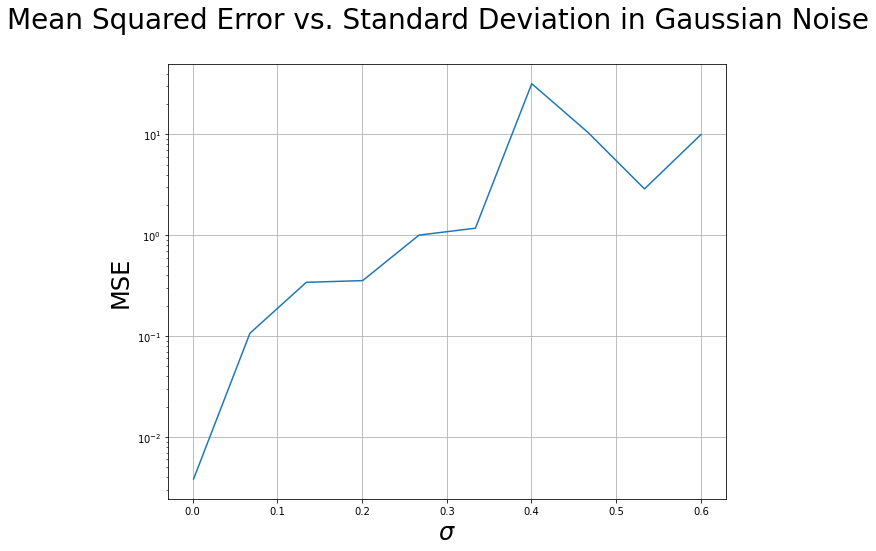

In [6]:
numRuns = 20
sigma_list = np.linspace(0.001, 0.6, 10)
total_MSE_list = np.zeros(len(sigma_list))
for i in range(numRuns):
    MSE_list = []
    for j in range(len(sigma_list)):
        sigma = np.zeros((feature_count, feature_count))
        sigmaVal = sigma_list[j]
        np.fill_diagonal(sigma, sigmaVal)
        print(sigmaVal)
        #noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
        noise = cn.powerlaw_psd_gaussian(beta, (n_of_ic, len(tvals), feature_count)) * (sigmaVal + 0.03)
        model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
        model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
        model.print()
        simulations = []
        # create simulations list to hold simulated data for corresponding IC
        for k in range(n_of_ic):
            # problem area with warnings
            #print(netswitch_x0s[k])
            netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint", integrator_kws=integrator_keywords)
            simulations.append(netswitch_sim) 
        MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
        MSE_list.append(MSE)
        #print(f"List for sigma={sigmaVal}: {MSE_list}")
    total_MSE_list = total_MSE_list + np.asarray(MSE_list)
    print(sigma_list)
    print(MSE_list)
total_MSE_list = total_MSE_list / numRuns
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
plt.yscale('log')

500
(500, 2)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
[37.3578045243963, 36.37379970329704, 29.841768973750906, 27.676998815722346, 26.937230446945765, 33.23314990542521, 28.331078676135323, 36.061445615625104, 33.96751323446484, 33.07196064090767, 33.496691804194015, 33.00569735154315, 32.235021649114294, 33.119658136402556, 29.076400317310586, 33.83599033230518, 34.974040063692, 28.676922708877836, 234.49789074432988, 33.40674281423231]


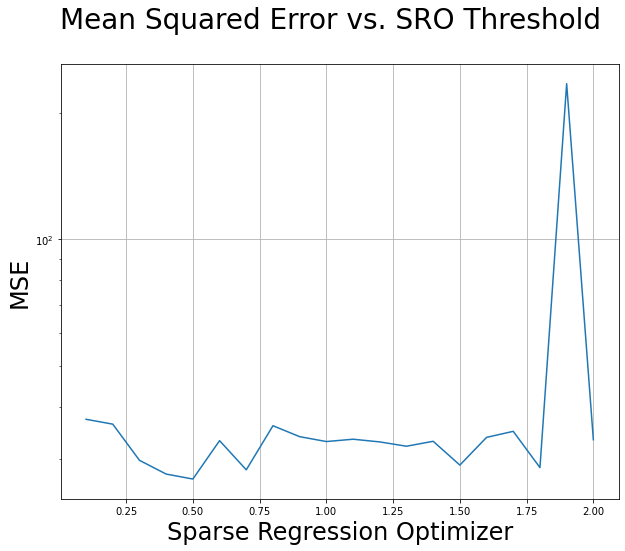

In [70]:
# test of model w/ varying threshold
# edit in progress
T = 50
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 500)
n_of_ic = 500
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
#sigma = 0.01
threshold_list = np.linspace(0.1, 2, 20)
mu = np.zeros(feature_count)

MSE_list = []
netswitch_train_multi = []

# creation of TRUE data/solution
for i in range(n_of_ic):
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
sigma = np.zeros((feature_count, feature_count))
sigmaVal = 0.2
np.fill_diagonal(sigma, sigmaVal)
# figure out sigma threshold with rmse for prev. cell 
# train models
for j in range(len(threshold_list)):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold_list[j])
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint")
        simulations.append(netswitch_sim) 
    #MSE = np.square(np.subtract(netswitch_train_multi, simulations)).mean()
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (feature_count * len(tvals) * n_of_ic)
    MSE_list.append(MSE)
print(threshold_list)
print(MSE_list)
axs.plot(threshold_list, MSE_list)
axs.set(xlabel="Sparse Regression Optimizer", ylabel="MSE")
plt.grid(True)
plt.xlabel("Sparse Regression Optimizer", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. SRO Threshold', fontsize=28)
plt.savefig("C:/Users/UserALai/Downloads\img.svg", bbox_inches='tight')
plt.yscale('log')

## Implementation of Network switch with SINDy-PI

See notebook 9 for relevant exmaple on 1D example. They use:
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x} \longrightarrow \dot{x} = \frac{3}{5} -3 x - \frac{10}{3} x\dot{x}$$


Gene network switch system written implicitly:
$$ \dot{u} = -u + \frac{a}{b+v^\beta} \longrightarrow b\dot{u} + v^{\beta}\dot{u} + bu + uv^{\beta} = a$$
$$ \dot{v} = -v + \frac{c}{d+u^\gamma} \longrightarrow d\dot{v} + u^{\gamma}\dot{v} + dv + vu^{\gamma} = c $$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
import sympy as sp

In [2]:
# Defining the system
a, b = 2, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a / (1+v**beta))
dvdt = lambda u, v: -v + (b / (1+u**gamma))
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
var = ['u', 'v']
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


In [96]:
# training set
r = len(var) # appears to be number of variables in example (x0, x1, x2,...)
dt = 0.01
T = 4
t = np.arange(0, T, dt)
t_span = (t[0], t[-1])
netswitch0_train = np.random.random(r) * 5
netswitch_train = solve_ivp(netswitch, t_span, netswitch0_train, t_eval=t, **integrator_keywords).y.T
print(netswitch0_train)
netswitch_train_multi = []
n_of_ic = 10

netswitch_x0s = (np.random.rand(n_of_ic, r) * 5)
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, t_span, netswitch_x0s[i], t_eval=t
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
netswitch_x0s
#print(netswitch_train_multi)
#print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
len(netswitch_train_multi)

[4.28094537 4.72941255]
(400, 2)


10

In [30]:
print(len(netswitch_train_multi))

100


In [ ]:
# PDE Library implementation
library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
"""
x_dot_library_functions = [
    lambda x: x
]
"""
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
#    lambda x: x
]
#""" PDELibrary lost implicit_terms in 1.7.1
pde_library = ps.PDELibrary(
    library_functions=library_functions,
    spatial_grid=netswitch_train,
    #temporal_grid=t,
    function_names=library_function_names,
    include_bias=False,
    #implicit_terms=True,
    derivative_order=1,
    include_interaction=True,
)
#"""
"""
sindy_library = ps.SINDyPILibrary(
    library_functions=library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t,
    function_names=library_function_names,
    include_bias=True,
)
"""
sindy_opt = ps.SINDyPI(
    threshold=1e-0,
    tol=1e-8,
    thresholder="l1",
    max_iter=20000,
    normalize_columns=True
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=pde_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True)#,
    #feature_names=['u', 'v']
)
model.fit(netswitch_train_multi, t=dt, multiple_trajectories=True)
#model.fit(netswitch_train, t=dt, multiple_trajectories=False)
model.feature_names = model.get_feature_names()

model.print()
pde_library.get_feature_names()


In [110]:
print((netswitch_train_multi[0].shape))

(20001, 2)


In [97]:
# generalized library testing 
# gets u dot
library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y: x * y ** 2,
    lambda x, y: x ** 2 * y ,
]
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
)

x_dot_library_functions = [
    lambda x: x
]
# only consist of xn_dot
sindy_library = ps.SINDyPILibrary(
    library_functions=[],
    x_dot_library_functions=x_dot_library_functions,
    t=t,
    function_names=[lambda x: x],
)

# only consist of constant term 1
constant_library = ps.CustomLibrary(
    library_functions=[],
    function_names=[],
    include_bias=True,
)

sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    thresholder="l1",
    max_iter=40000,
)

# Initialize the inputs
inputs_u_temp = np.tile([0, 1], 3)
inputs_per_u_library = np.reshape(inputs_u_temp, (3, 2))
inputs_per_u_library[2, 1] = 0

generalized_library = ps.GeneralizedLibrary(
    [constant_library, custom_library, sindy_library],
    tensor_array=[[0,1,1]],
    inputs_per_library=inputs_per_u_library
)

# Issue running multiple_traj. with generalized_library
u_model = ps.SINDy(feature_library=generalized_library,
                 optimizer=sindy_opt,
                 differentiation_method=ps.FiniteDifference(drop_endpoints=False),
                )

u_model.fit(netswitch_train_multi, t=t, multiple_trajectories=True)
#u_model.fit(netswitch_train, t=dt, multiple_trajectories=False)

# lhs= gets the function names since print() will miss the fact that we're using SINDyPI
u_model.print(lhs=u_model.get_feature_names())
generalized_library.get_feature_names()
u_model.get_feature_names()

C:\Users\UserALai\miniconda3\lib\site-packages\pysindy\feature_library\sindy_pi_library.py:161: UserWarning: This library is deprecated in PySINDy versions > 1.7. Please use the PDE or WeakPDE libraries instead. 
  warnings.warn(


Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Model  13
Model  14
Model  15
1 = 0.562 x0 + 0.084 x1 + 0.028 x0x1 + -0.030 x0x0 + -0.011 x1x1 + 0.404 x0x1x1 + -0.036 x0x0x1 + 0.459 x0_dot + -0.017 x0 x0_dot + 0.058 x1 x0_dot + -0.039 x0x1 x0_dot + -0.004 x0x0 x0_dot + 0.404 x1x1 x0_dot + -0.002 x0x1x1 x0_dot + 0.002 x0x0x1 x0_dot
x0 = 1.557 1 + -0.188 x1 + 0.023 x0x1 + 0.104 x0x0 + 0.026 x1x1 + -0.588 x0x1x1 + 0.064 x0x0x1 + -0.693 x0_dot + 0.078 x0 x0_dot + -0.121 x1 x0_dot + 0.080 x0x1 x0_dot + 0.004 x0x0 x0_dot + -0.569 x1x1 x0_dot + -0.001 x0x1x1 x0_dot + -0.002 x0x0x1 x0_dot
x1 = 2.133 1 + -1.721 x0 + -0.300 x0x1 + 0.320 x0x0 + 0.135 x1x1 + 0.055 x0x1x1 + 0.378 x0x0x1 + -0.724 x0_dot + 0.354 x0 x0_dot + -0.646 x1 x0_dot + 0.365 x0x1 x0_dot + -0.016 x0x0 x0_dot + 0.086 x1x1 x0_dot + 0.007 x0x0x1 x0_dot
x0x1 = 0.739 1 + 0.222 x0 + -0.316 x1 + -0.264 x0x0 + 0.030 x1x1 + 0.265 x0x1x1 + 0.327 x0x0x1 + -0.228 x0_do

['1',
 'x0',
 'x1',
 'x0x1',
 'x0x0',
 'x1x1',
 'x0x1x1',
 'x0x0x1',
 'x0_dot',
 'x0 x0_dot',
 'x1 x0_dot',
 'x0x1 x0_dot',
 'x0x0 x0_dot',
 'x1x1 x0_dot',
 'x0x1x1 x0_dot',
 'x0x0x1 x0_dot']

In [14]:
# getting v_dot w/ generalized lib
# Initialize the inputs
inputs_v_temp = np.tile([0, 1], 3)
inputs_per_v_library = np.reshape(inputs_v_temp, (3, 2))
inputs_per_v_library[2, 0] = 1

generalized_library = ps.GeneralizedLibrary(
    [constant_library, custom_library, sindy_library],
    tensor_array=[[0,1,1]],
    inputs_per_library=inputs_per_v_library
)
# Issue running multiple_traj. with generalized_library
v_model = ps.SINDy(feature_library=generalized_library,
                 optimizer=sindy_opt,
                 differentiation_method=ps.FiniteDifference(drop_endpoints=False),
                )

v_model.fit(netswitch_train_multi, t=dt, multiple_trajectories=True)
#v_model.fit(netswitch_train, t=dt, multiple_trajectories=False)

# lhs= gets the function names since print() will miss the fact that we're using SINDyPI
v_model.print(lhs=v_model.get_feature_names())
generalized_library.get_feature_names()
v_model.get_feature_names()

Model  0


C:\Users\UserALai\miniconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Model  13
Model  14
Model  15
1 = 0.799 x0 + 0.826 x1 + -0.442 x0x1 + -0.149 x0x0 + -0.149 x1x1 + 0.048 x0x1x1 + 0.053 x0x0x1 + -0.004 x1_dot + 0.001 x0 x1_dot + 0.003 x1 x1_dot + -0.001 x0x1 x1_dot
x0 = 1.184 1 + -0.927 x1 + 0.527 x0x1 + 0.203 x0x0 + 0.157 x1x1 + -0.048 x0x1x1 + -0.074 x0x0x1 + 0.004 x1_dot + -0.001 x0 x1_dot + -0.003 x1 x1_dot + 0.001 x0x1 x1_dot + -0.001 x0x0 x1_dot
x1 = 1.036 1 + -0.785 x0 + 0.524 x0x1 + 0.133 x0x0 + 0.201 x1x1 + -0.072 x0x1x1 + -0.050 x0x0x1 + -0.008 x1_dot + 0.007 x0 x1_dot + 0.003 x1 x1_dot + -0.002 x0x1 x1_dot + -0.001 x0x0 x1_dot
x0x1 = -1.758 1 + 1.413 x0 + 1.661 x1 + -0.257 x0x0 + -0.302 x1x1 + 0.114 x0x1x1 + 0.119 x0x0x1 + 0.016 x1_dot + -0.014 x0 x1_dot + -0.006 x1 x1_dot + 0.005 x0x1 x1_dot + 0.003 x0x0 x1_dot + 0.001 x1x1 x1_dot + -0.001 x0x0x1 x1_dot
x0x0 = -4.722 1 + 4.332 x0 + 3.354 x1 + -2.042 x0x1 + -0.496 x1x1 + 0.109 x0x1

['1',
 'x0',
 'x1',
 'x0x1',
 'x0x0',
 'x1x1',
 'x0x1x1',
 'x0x0x1',
 'x1_dot',
 'x0 x1_dot',
 'x1 x1_dot',
 'x0x1 x1_dot',
 'x0x0 x1_dot',
 'x1x1 x1_dot',
 'x0x1x1 x1_dot',
 'x0x0x1 x1_dot']

### Now we need to reformat all the feature strings for conversion into symbolic variables
So we have all these nice models but these are implicit ODEs, and the default Python solvers (solve_ivp and odeint) cannot solve implicit ODEs. There are two options although we only illustrate the first option below; we must convert the equations into symbolic variables and then either (1) use SymPy to symbolically solve the equation for $\dot{x}$, after which the equation is no longer implicit and can be solved with the default Python solves, or (2) convert the equations into a symbolic differential algebraic equation (DAE), which can be numerically solved with the diffeqpy Python package (but requires Julia to be installed). 

In [98]:
features = u_model.get_feature_names()
features[0] = "1"
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + " x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + " x", "x" + str(j) + " * x")
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
for i in range(nfeatures):
    temp_string = features[i].replace(" ", "")
    features[i] = temp_string

print(features)
print(features_formatted)
coefs = u_model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]
print(sym_theta)

['1', 'x0', 'x1', 'x0x1', 'x0x0', 'x1x1', 'x0x1x1', 'x0x0x1', 'x0_dot', 'x0x0_dot', 'x1x0_dot', 'x0x1x0_dot', 'x0x0x0_dot', 'x1x1x0_dot', 'x0x1x1x0_dot', 'x0x0x1x0_dot']
['1', 'x0', 'x1', 'x0 * x1', 'x0 * x0', 'x1 * x1', 'x0 * x1 * x1', 'x0 * x0 * x1', 'x0_dot', 'x0 * x0_dot', 'x1 * x0_dot', 'x0 * x1 * x0_dot', 'x0 * x0 * x0_dot', 'x1 * x1 * x0_dot', 'x0 * x1 * x1 * x0_dot', 'x0 * x0 * x1 * x0_dot']
[1, x0, x1, x0x1, x0x0, x1x1, x0x1x1, x0x0x1, x0_dot, x0x0_dot, x1x0_dot, x0x1x0_dot, x0x0x0_dot, x1x1x0_dot, x0x1x1x0_dot, x0x0x1x0_dot]


In [99]:
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    sym_equations.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 10)), sym_features[i]
        )
    )
    sym_equations_rounded.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 2)), sym_features[i]
        )
    )
    print(sym_theta[i], " = ", sym_equations_rounded[i][0])

1  =  0.56*x0 + 0.46*x0_dot - 0.03*x0x0 - 0.02*x0x0_dot - 0.04*x0x0x1 + 0.03*x0x1 - 0.04*x0x1x0_dot + 0.4*x0x1x1 + 0.08*x1 + 0.06*x1x0_dot - 0.01*x1x1 + 0.4*x1x1x0_dot
x0  =  1.56*1 - 0.69*x0_dot + 0.1*x0x0 + 0.08*x0x0_dot + 0.06*x0x0x1 + 0.02*x0x1 + 0.08*x0x1x0_dot - 0.59*x0x1x1 - 0.19*x1 - 0.12*x1x0_dot + 0.03*x1x1 - 0.57*x1x1x0_dot
x1  =  2.13*1 - 1.72*x0 - 0.72*x0_dot + 0.32*x0x0 + 0.35*x0x0_dot - 0.02*x0x0x0_dot + 0.38*x0x0x1 + 0.01*x0x0x1x0_dot - 0.3*x0x1 + 0.37*x0x1x0_dot + 0.05*x0x1x1 - 0.65*x1x0_dot + 0.13*x1x1 + 0.09*x1x1x0_dot
x0x1  =  0.74*1 + 0.22*x0 - 0.23*x0_dot - 0.26*x0x0 - 0.17*x0x0_dot + 0.01*x0x0x0_dot + 0.33*x0x0x1 + 0.19*x0x1x0_dot + 0.27*x0x1x1 + 0.04*x0x1x1x0_dot - 0.32*x1 - 0.36*x1x0_dot + 0.03*x1x1 + 0.11*x1x1x0_dot
x0x0  =  -2.79*1 + 3.54*x0 + 0.94*x0_dot - 0.87*x0x0_dot + 0.03*x0x0x0_dot - 0.23*x0x0x1 - 0.01*x0x0x1x0_dot - 0.93*x0x1 - 0.42*x0x1x0_dot + 0.41*x0x1x1 + 0.05*x0x1x1x0_dot + 1.19*x1 + 0.68*x1x0_dot - 0.17*x1x1 + 0.12*x1x1x0_dot
x1x1  =  -15.47*1 +

Formatting equations into $\dot{u}=f(u, v)$ form

In [100]:
# Define the ODE symbol variables
t_sym = sp.symbols("t_sym")
x_sym = sp.symbols("x:%d" % r)
x_dot_sym = sp.symbols("x:%d_dot" % r)
print(x_dot_sym)
# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
sym_equations_rounded_formatted = []
for i in range(nfeatures):
    #print(f"base ={sym_equations[i]}")
    temp_string = str(sym_equations[i])
    temp_rounded_string = str(sym_equations_rounded[i])
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = temp_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")

        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
    sym_equations_formatted.append(temp_string)
    sym_equations_rounded_formatted.append(temp_rounded_string)
    #print(f"formatted and rounded = {sym_equations_rounded_formatted[i]}")

# Now that the equations are mathematically formatted, 
# solve for x_dot0 in the algebraic equation.
sym_equations_simplified = []
sym_equations_rounded_simplified = []
for i in range(nfeatures):
    print(i)
    sym_equations_simplified.append(
        sp.factor(sp.solve(
            sp.Add(
                sp.sympify(sym_equations_formatted)[i][0],
                -sp.sympify(features_formatted[i]),
            ),
            x_dot_sym[0],
        ))
    )
    rounded = sp.factor(sp.solve(
        sp.Add(
            sp.sympify(sym_equations_rounded_formatted)[i][0],
            -sp.sympify(features_formatted[i]),
        ),
        x_dot_sym[0],
    ))
    #print(rounded)
    #print(f"variable = {var[j]}, {x_dot_sym[j]} = {rounded}")
    if len(rounded) != 0:
        rounded_temp = rounded[0]
        #print(rounded_temp)
        for a in sp.preorder_traversal(rounded):
            if isinstance(a, sp.Float):
                rounded_temp = rounded_temp.subs(a, round(a, 2))
        sym_equations_rounded_simplified.append(rounded_temp)
    else:
        sym_equations_rounded_simplified.append([])

(x0_dot, x1_dot)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Testing SymPy simplification methods

https://docs.sympy.org/latest/tutorial/simplification.html

In [40]:
sp.factor(sp.solve(
            sp.Add(
                sp.sympify(sym_equations_formatted)[i][0],
                -sp.sympify(features_formatted[i]),
            ),
            x_dot_sym[0],
        )[0])

2.04413119526485*(0.0577267289599513*x0**2*x1 + 0.00859004206730981*x0**2 - 0.434095347432838*x0*x1**2 - 0.195289491422043*x0*x1 - 0.515570326647711*x0 - 0.0700734546078822*x1**2 + 0.144279444135927*x1 + 1.0)/(0.0377495252680102*x0**2*x1 - 0.0540320477071132*x0**2 - 0.0201955501360928*x0*x1**2 - 0.286784549985735*x0*x1 + 0.25942830496837*x0 + 1.0*x1**2 + 0.443902770003389*x1 + 0.652527724621665)

In [26]:
sp.solve(
            sp.Add(
                sp.sympify(sym_equations_formatted)[i][0],
                -sp.sympify(features_formatted[i]),
            ),
            x_dot_sym[0],
        )[0]

10.0*(-175374056717537.0*x0**2*x1 + 948537068434854.0*x0**2 - 609626276900963.0*x0*x1**2 + 1.94934611956493e+15*x0*x1 - 3.97786759858779e+15*x0 + 622984916422298.0*x1**2 - 2.85549933878555e+15*x1 + 4.11055097728105e+15)/(-1.0e+15*x0**2*x1 + 1.98011287249801e+15*x0**2 + 1.46635305694664e+15*x0*x1**2 + 670715927467072.0*x0*x1 - 1.33771722863377e+16*x0 - 166412759216641.0*x1**2 + 2.42668480404267e+15*x1 + 1.90807113364081e+16)

x_test isolated for reproducibility.

In [102]:
x0_test = np.random.rand(r) * 5
x0_test

array([4.69883765, 2.91406351])

Graphing of test simulation

(0.0, 6.0)

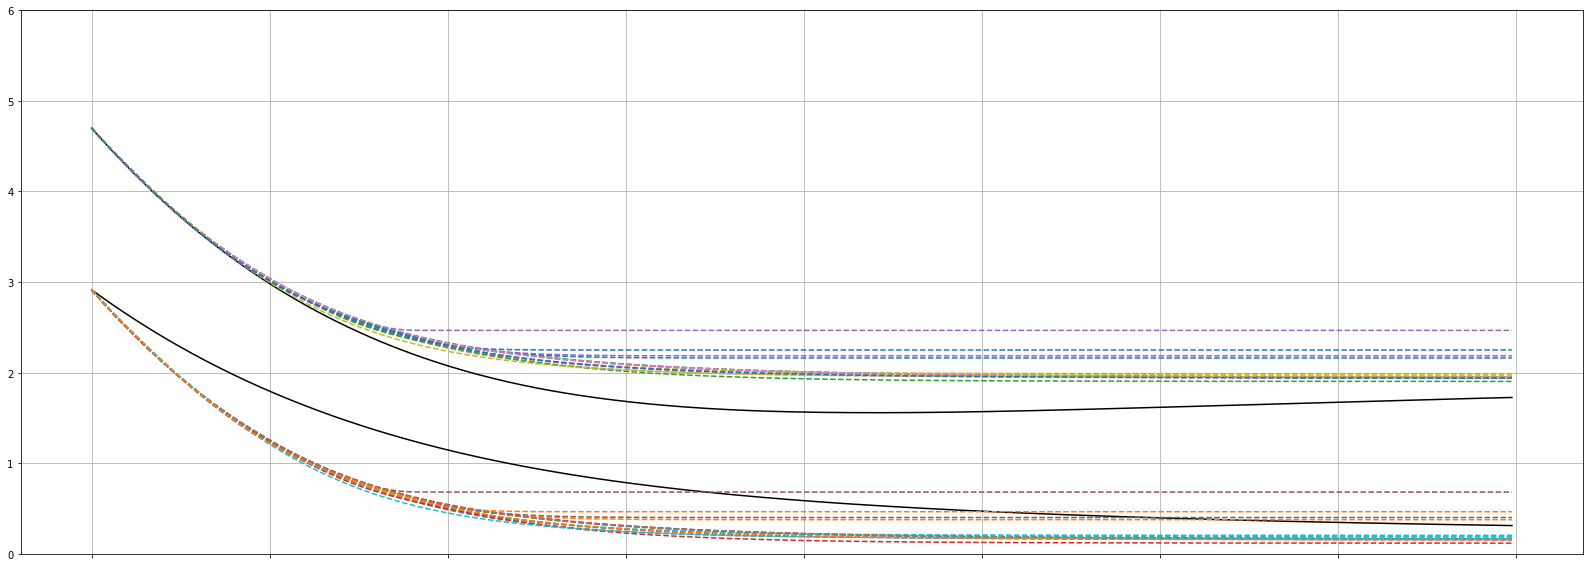

In [108]:
a, b = 2, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a / (1+v**beta))
dvdt = lambda u, v: -v + (b / (1+u**gamma))
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
x_test = solve_ivp(netswitch, t_span, x0_test, t_eval=t).y.T
# Plot the results for each of the models
plt.figure(figsize=(28, 10))
plt.plot(t, x_test, color="k", linestyle="solid", label="True")
for i in range(nfeatures):
    ax = plt.gca()
    if i != nfeatures - 1:
        ax.set_xticklabels([])
    if len(sym_equations_simplified[i]) != 0:
        # ODE 
        ODE_Func = sp.lambdify([t_sym, x_sym], sym_equations_simplified[i][0])

        # Now simulate the system we identified
        x_test_sim = solve_ivp(ODE_Func, t_span, x0_test, t_eval=t).y.T
        if (
            np.linalg.norm(x_test_sim) < 1e3
            and sym_equations_rounded_simplified[i] != 0
        ):
            plt.plot(
                t,
                x_test_sim,
                linestyle="dashed",
                label=str(sp.sympify(features_formatted[i]))
                + " = "
                + str(sym_equations_rounded_simplified[i]),
            )
plt.grid(True)
ax.set_ylim([0, 6])
#plt.legend(fontsize=8)

[1.421489026361558, 1.4214465021271017, 1.4492337885288145, 1.4167203920378824, 1.4224051459590574, 1.774565502880548, 1.421514237218937, 1.5197456530742581, 1.4216273788578482, 1.4184936028229325, 1.438144320733949, 1.4482785922512056, 1.4148101815331466, 1.4214612221773455, 1.4073907808087756, 1.4143968503432973]


1.5773548952263*(0.197442174392898*x0**2*x1 - 0.311497809330691*x0**2 - 0.304648803687256*x0*x1**2 - 0.749991350516221*x0*x1 + 0.164378351700271*x0 - 0.00185063289433118*x1**2 + 0.000870706871568645*x1 + 1.0)/(0.151340109763786*x0**2*x1 - 0.352635750926261*x0**2 - 0.206561438926209*x0*x1**2 - 0.0382548997551282*x0*x1 + 1.0*x0 + 0.919190249064234*x1**2 - 0.254584397510816*x1 + 0.570930245796254)

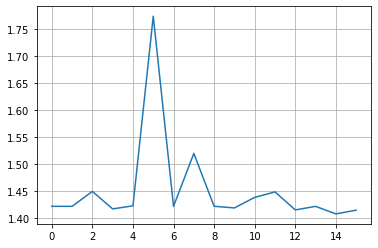

In [104]:
# model Errors for udot
a, b = 2, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a / (1+v**beta))
dvdt = lambda u, v: -v + (b / (1+u**gamma))
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])

# Plot the results for each of the models
x_test = solve_ivp(netswitch, t_span, x0_test, t_eval=t).y.T
#plt.plot(t, x_test, color="k", linestyle="solid", label="True")
u_dot_true = u_model.differentiate(x_test[:, 0])
u_dots = []
for i in range(nfeatures):
    if len(sym_equations_simplified[i]) != 0:
        ODE_Func = sp.lambdify([t_sym, x_sym], sym_equations_simplified[i][0])
        u_dots.append(ODE_Func(t, [x_test[:,0], x_test[:,1]]))
u_dot_error = [(1/20)*np.linalg.norm(u_dot_true.T[0] - u_dot) for u_dot in u_dots]
print(u_dot_error)
plt.plot(range(16), u_dot_error)
plt.grid(True)
# res is index of minimum model error
temp = min(u_dot_error)
res = [i for i, j in enumerate(u_dot_error) if j == temp]
sym_equations_simplified[res[0]][0]

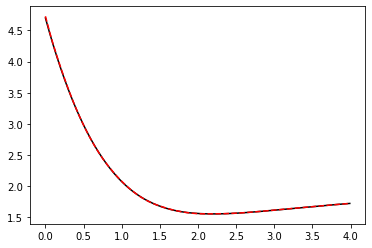

In [105]:
us = u_model.predict(x_test)[:, 1]
plt.plot(t, x_test[:, 0], 'k')
plt.plot(t, us,'r--')

In [81]:
u_model.predict(x_test)[0]

AxesArray([ 1.00538050e+00,  2.51778083e+00,  5.76128773e-03,
            1.90296669e-01,  6.56349715e+00,  1.85663420e-01,
            4.05433580e-03,  5.82833411e-01, -5.46463813e-01,
           -1.22097509e+00, -1.08717818e-01,  8.52301270e-02,
           -3.31946476e+00, -8.33145093e-04, -1.17150918e+00,
           -1.26475057e-01])

In [76]:
x_test

array([[2.53251841, 0.04876567],
       [2.52717172, 0.04962504],
       [2.52187653, 0.05048078],
       [2.51663233, 0.05133288],
       [2.51143859, 0.05218136],
       [2.50629477, 0.05302623],
       [2.50120036, 0.05386752],
       [2.49615486, 0.05470523],
       [2.49115775, 0.05553937],
       [2.48620853, 0.05636996],
       [2.48130663, 0.05719699],
       [2.47645078, 0.05802033],
       [2.47164042, 0.05883996],
       [2.46687515, 0.05965591],
       [2.46215457, 0.0604682 ],
       [2.45747831, 0.06127685],
       [2.45284598, 0.0620819 ],
       [2.44825719, 0.06288337],
       [2.44371157, 0.06368128],
       [2.43920872, 0.06447565],
       [2.43474827, 0.06526651],
       [2.43032985, 0.06605387],
       [2.42595308, 0.06683777],
       [2.42161759, 0.06761822],
       [2.417323  , 0.06839525],
       [2.41306894, 0.06916887],
       [2.40885505, 0.0699391 ],
       [2.40468096, 0.07070597],
       [2.4005463 , 0.07146949],
       [2.39645071, 0.07222969],
       [2.

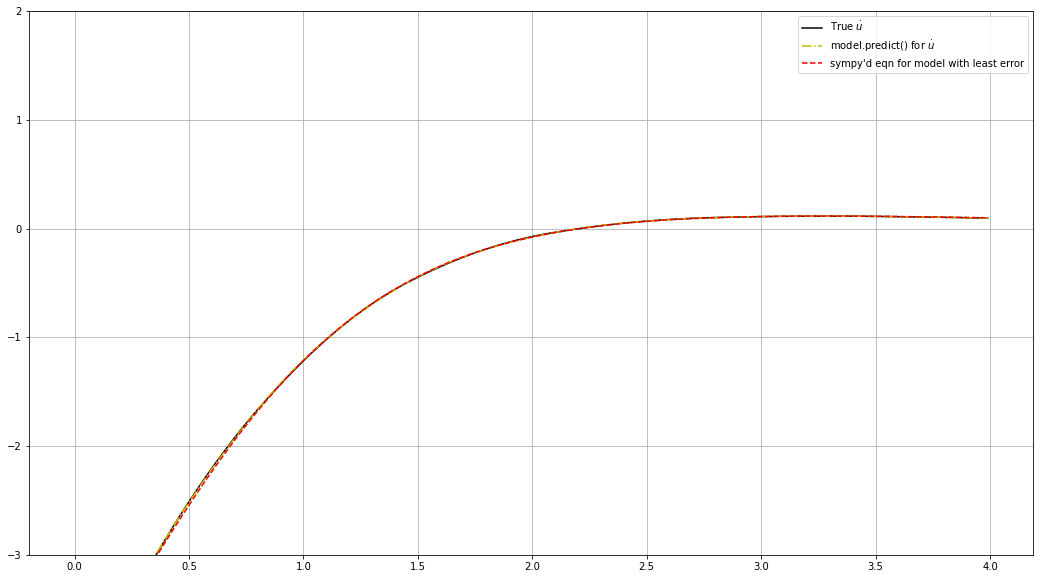

In [106]:
# derivative comparison
plt.figure(figsize=(18, 10))
# best model 
ODE_Func = sp.lambdify([t_sym, x_sym], sym_equations_simplified[res[0]][0])
plt.plot(t, u_model.differentiate(x_test[:,0], t), 'k', label='True $\dot{u}$')
plt.plot(t, u_model.predict(x_test)[:, 8],'y-.',label='model.predict() for $\dot{u}$')
plt.plot(t, ODE_Func(t, [x_test[:,0], x_test[:,1]]), 'r--', label='sympy\'d eqn for model with least error')
ax = plt.gca()
plt.grid(True)
ax.set_ylim([-3, 2])
plt.legend()

In [107]:
res[0]

14

In [58]:
np.linalg.norm(u_dot_true.T[0] - u_dots[8])/np.linalg.norm(u_dot_true)

100.39058477060676

In [67]:
1/20*(np.linalg.norm(u_dot_true.T[0] - u_dots[8]))

0.19953551475636744

In [56]:
(u_dot_true- u_dots[8]).shape

(400, 400)

In [54]:
u_dot_true.T[0] - u_dots[8]

AxesArray([0.54288436, 0.5375873 , 0.53234627, 0.52716037, 0.52202902,
           0.51695162, 0.51192757, 0.5069563 , 0.50203723, 0.49716976,
           0.49235284, 0.48758512, 0.48286637, 0.47819623, 0.47357424,
           0.46899996, 0.46447294, 0.45999273, 0.45555889, 0.45117099,
           0.44682857, 0.44253122, 0.4382785 , 0.43406998, 0.42990523,
           0.42578383, 0.42170537, 0.41766941, 0.41367555, 0.40972337,
           0.40581246, 0.40194241, 0.39811282, 0.39432328, 0.39057339,
           0.38686275, 0.38319096, 0.37955764, 0.37596238, 0.3724048 ,
           0.36888451, 0.36540113, 0.36195427, 0.35854355, 0.35516859,
           0.35182903, 0.34852447, 0.34525456, 0.34201893, 0.33881719,
           0.335649  , 0.33251398, 0.32941178, 0.32634204, 0.3233044 ,
           0.3202985 , 0.317324  , 0.31438054, 0.31146778, 0.30858536,
           0.30573295, 0.30291019, 0.30011676, 0.29735232, 0.29461652,
           0.29190903, 0.28922953, 0.28657767, 0.28395314, 0.2813556 ,
      

## Repressilator/Gene Network Clock

In [6]:
# General from of equations; reference pg 112
# mdot_i = -m_i + (alpha / (1+p_j**n)) + a0
# pdot_i = -beta * (p_i - m_i)
# if i = lacI, tetR, cl
# then j = cl, lacI, tetR

# is there a better way of doing this? kinda spaghetti code 
#mdot_lacI = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_lacI + (alpha / (1+p_cl**n)) + a0
#mdot_tetR = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_tetR + (alpha / (1+p_lacI**n)) + a0
#mdot_cl = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_cl + (alpha / (1+p_tetR**n)) + a0
#pdot_lacI = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_lacI - m_lacI)
#pdot_tetR = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_tetR - m_tetR)
#pdot_cl = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_cl - m_cl)

alpha=50
a0=0
n=2
beta=0.2
# x in form:
# [m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl]
# [0     , 1     , 2   , 3     , 4     , 5   ]
def repressilator(t, x):
    return [
        -x[0] + (alpha / (1 + x[5]**n)) + a0,
        -x[1] + (alpha / (1+x[3]**n)) + a0,
        -x[2] + (alpha / (1+x[4]**n)) + a0,
        -beta * (x[3] - x[0]),
        -beta * (x[4] - x[1]),
        -beta * (x[5] - x[2])
    ]

T = 300
dt = 0.01
trange = np.array([0, T])
tvals = np.arange(0, T + dt, dt)
x0 = np.array([0.2, 0.1, 0.3, 0.1, 0.4, 0.5])
x_train1 = solve_ivp(repressilator, trange, x0, t_eval=tvals).y

alpha=50
a0=1
n=2
beta=0.2
#T=100
trange2 = np.array([0, T])
tvals2 = np.arange(0, T + dt, dt)

x_train2 = solve_ivp(repressilator, trange2, x0, t_eval=tvals2).y
"""
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(tvals, x_train1[0, ], "r", label="$m_{lacI}$",)
axs[0].plot(tvals, x_train1[1, :], "g", label="$m_{tetR}$")
axs[0].plot(tvals, x_train1[2, :], "b", label="$m_{cl}$")
axs[0].plot(tvals, x_train1[3, :], "r--", label="$p_{lacI}$")
axs[0].plot(tvals, x_train1[4, :], "g--", label="$p_{tetR}$")
axs[0].plot(tvals, x_train1[5, :], "b--", label="$p_{cl}$")

axs[0].legend()
axs[0].set(xlabel="t", title="Oscillatory Repressilator solutions")

axs[1].plot(tvals2, x_train2[0, ], "r", label="$m_{lacI}$",)
axs[1].plot(tvals2, x_train2[1, :], "g", label="$m_{tetR}$")
axs[1].plot(tvals2, x_train2[2, :], "b", label="$m_{cl}$")
axs[1].plot(tvals2, x_train2[3, :], "r--", label="$p_{lacI}$")
axs[1].plot(tvals2, x_train2[4, :], "g--", label="$p_{tetR}$")
axs[1].plot(tvals2, x_train2[5, :], "b--", label="$p_{cl}$")

axs[1].legend()
axs[1].set(xlabel="t", title="Convergent Repressilator solutions")
"""

'\nfig, axs = plt.subplots(1, 2, figsize=(20, 8))\naxs[0].plot(tvals, x_train1[0, ], "r", label="$m_{lacI}$",)\naxs[0].plot(tvals, x_train1[1, :], "g", label="$m_{tetR}$")\naxs[0].plot(tvals, x_train1[2, :], "b", label="$m_{cl}$")\naxs[0].plot(tvals, x_train1[3, :], "r--", label="$p_{lacI}$")\naxs[0].plot(tvals, x_train1[4, :], "g--", label="$p_{tetR}$")\naxs[0].plot(tvals, x_train1[5, :], "b--", label="$p_{cl}$")\n\naxs[0].legend()\naxs[0].set(xlabel="t", title="Oscillatory Repressilator solutions")\n\naxs[1].plot(tvals2, x_train2[0, ], "r", label="$m_{lacI}$",)\naxs[1].plot(tvals2, x_train2[1, :], "g", label="$m_{tetR}$")\naxs[1].plot(tvals2, x_train2[2, :], "b", label="$m_{cl}$")\naxs[1].plot(tvals2, x_train2[3, :], "r--", label="$p_{lacI}$")\naxs[1].plot(tvals2, x_train2[4, :], "g--", label="$p_{tetR}$")\naxs[1].plot(tvals2, x_train2[5, :], "b--", label="$p_{cl}$")\n\naxs[1].legend()\naxs[1].set(xlabel="t", title="Convergent Repressilator solutions")\n'

## Morris-Lecar Model
    

[Text(0.5, 0, 't'), Text(0.5, 1.0, 'Morris-Lecar solutions')]

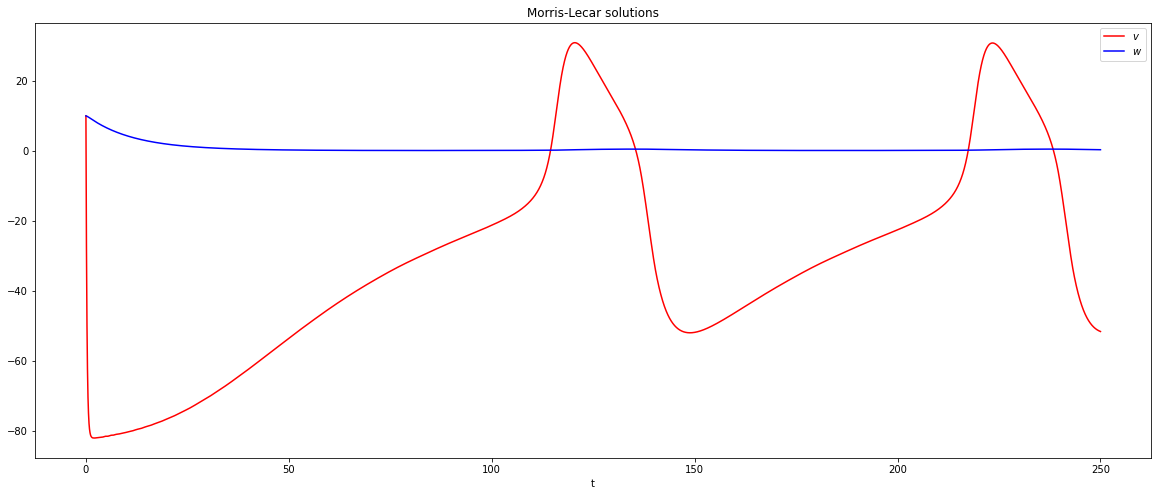

In [5]:
gCa, gK, gL, vCa, vK, vL, C, phi, i, v_1, v_2, v_3, v_4 = 4.4, 8, 2, 120, -84, -60, 20, 0.04, 90, -1.2, 18, 2, 30
# helper functions v ^ parameters
m_inf = lambda v: 0.5 * (1 + np.tanh((v - v_1) / v_2))
w_inf = lambda v: 0.5 * (1 + np.tanh((v - v_3) / v_4))
t_w = lambda v: 1 / (np.cosh((v-v_3) / (2 * v_4)))

# x = [v, w]
def morris_lecar(t, x):
    return [
        (1/C) * (i-gCa * m_inf(x[0]) * (x[0] - vCa)-gK * x[1] * (x[0]-vK) - gL * (x[0]-vL)),
        (1/t_w(x[0])) * (phi * (w_inf(x[0]) - x[1]))
    ]

T = 250
dt = 0.01
trange = np.array([0, T])
tvals = np.arange(0, T + dt, dt)
x0 = np.array([10, 10])

MorLec_train = solve_ivp(morris_lecar, trange, x0, t_eval=tvals).y

fig, axs = plt.subplots(figsize=(20, 8))
axs.plot(tvals, MorLec_train[0, ], "r", label="$v$")
axs.plot(tvals, MorLec_train[1, ], "b", label="$w$")


axs.legend()
axs.set(xlabel="t", title="Morris-Lecar solutions")